### Mount Google Drive, Import Libraries and Define Paths

In [22]:
# =============================================================================
# ENVIRONMENT SETUP + PATH CONFIGURATION (SERVER / COLAB COMPATIBLE)
# =============================================================================

import os
import sys
import importlib
from pathlib import Path
import string
import re
import gc
from datetime import timedelta
from scipy.stats.mstats import winsorize
import shutil

# -----------------------------------------------------------------------------
# 0) HARD SAFETY: cap native thread usage (prevents pthread_create EAGAIN)
#    MUST be set before importing numpy / scipy / pandas
# -----------------------------------------------------------------------------
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_MAX_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["BLIS_NUM_THREADS"] = "1"

# -----------------------------------------------------------------------------
# 1) Detect environment
# -----------------------------------------------------------------------------
IN_COLAB = "google.colab" in sys.modules

# -----------------------------------------------------------------------------
# 2) (Colab only) Mount Google Drive
# -----------------------------------------------------------------------------
if IN_COLAB:
    from google.colab import drive
    drive.mount("/content/drive")
    BASE_PATH = "/content/drive/MyDrive/Colab Notebooks"
else:
    # Server base path (your target)
    BASE_PATH = "/home/jovyan/work/hpool1/pseidel/test"

print("IN_COLAB:", IN_COLAB)
print("BASE_PATH:", BASE_PATH)

# -----------------------------------------------------------------------------
# 3) Sanity checks: path exists + write permission
# -----------------------------------------------------------------------------
BASE = Path(BASE_PATH)
if not BASE.exists():
    raise FileNotFoundError(f"BASE_PATH does not exist: {BASE}")

# quick write test (fails fast if you don't have permissions)
test_file = BASE / ".write_test_tmp"
try:
    test_file.write_text("ok", encoding="utf-8")
    test_file.unlink()
except Exception as e:
    raise PermissionError(f"No write permission in {BASE}. Error: {e}")

# -----------------------------------------------------------------------------
# 4) Environment check: ensure required packages import cleanly
# -----------------------------------------------------------------------------
required_packages = ["numpy", "scipy", "pandas", "linearmodels", "xlsxwriter"]

for pkg in required_packages:
    print(f"Importing {pkg} ...")
    importlib.import_module(pkg)
    print(f"{pkg} OK")

import numpy as np
import pandas as pd

# -----------------------------------------------------------------------------
# 5) Base paths and input/output locations
# -----------------------------------------------------------------------------
Input_file_path   = str(BASE / "Input")
Temp_file_path    = str(BASE / "Temp")
Output_file_path  = str(BASE / "Output")

Fundamentals_file_path = f"{Input_file_path}/WSFV_f_20250131.txt"
Current_file_path      = f"{Input_file_path}/WSCurrent_f_20250131.txt"
Calendar_file_path     = f"{Input_file_path}/WSCalendarPrd_f_20250131.txt"
Meta_file_path         = f"{Input_file_path}/WSMetaData_f_20250131.txt"
Excel_file_path        = f"{Input_file_path}/WS PIT Table Definitions V5 with start dates.xls"

MarketValues_file_path          = f"{Input_file_path}/Daily MV USD"
MarketValues_file_path_LC       = f"{Input_file_path}/Daily MV LC"
DailyTotalReturns_file_path     = f"{Input_file_path}/Daily Returns USD"
DailyIndexReturns_file_path     = f"{Input_file_path}/Daily Index Returns USD"
Constituents_file_path          = f"{Input_file_path}/Constituents.01.csv"
UniversalMatching_file_path     = f"{Input_file_path}/Universal Matching File"

Temp_file_path_GO  = f"{Temp_file_path}/TempGeneralOverview"
Temp_file_path_EoC = f"{Temp_file_path}/TempExtractionofCharacteristics"
Temp_file_path_DP  = f"{Temp_file_path}/TempDataPreparation"
Temp_file_path_A   = f"{Temp_file_path}/TempAnomalies"
Temp_file_path_R   = f"{Temp_file_path}/TempRegressionModel"

Relevant_items_path   = f"{Input_file_path}/RelevantItems.txt"
Relevant_items_path_A = f"{Input_file_path}/RelevantItems.txt"
Relevant_items_path_B = f"{Input_file_path}/RelevantItemsB.txt"
Relevant_items_path_C = f"{Input_file_path}/RelevantItemsC.txt"
Relevant_items_path_D = f"{Input_file_path}/RelevantItemsD.txt"

Subset_file_path = f"{Temp_file_path_GO}/Subsets"
Fundamentals_clean_file_path = f"{Temp_file_path_GO}/Fundamentals_clean.txt"
Current_clean_file_path      = f"{Temp_file_path_GO}/Current_clean.txt"
Calendar_clean_file_path     = f"{Temp_file_path_GO}/Input/Calendar_clean.txt"
Meta_clean_file_path         = f"{Temp_file_path_GO}/Input/Meta_clean.txt"

# -----------------------------------------------------------------------------
# 6) Ensure required directories exist
# -----------------------------------------------------------------------------
Path(Output_file_path).mkdir(parents=True, exist_ok=True)
Path(Temp_file_path_GO).mkdir(parents=True, exist_ok=True)
Path(Temp_file_path_EoC).mkdir(parents=True, exist_ok=True)
Path(Temp_file_path_DP).mkdir(parents=True, exist_ok=True)
Path(Temp_file_path_A).mkdir(parents=True, exist_ok=True)
Path(Temp_file_path_R).mkdir(parents=True, exist_ok=True)
Path(Subset_file_path).mkdir(parents=True, exist_ok=True)
Path(Path(Calendar_clean_file_path).parent).mkdir(parents=True, exist_ok=True)

# -----------------------------------------------------------------------------
# 7) Streaming / deduplication settings
# -----------------------------------------------------------------------------
CHUNK_SIZE = 2_000_000
DATE_COL = "PIT Date"
DEDUP_KEYS = ["ID", "ItemCode", DATE_COL]

print("Paths configured. Temp outputs ->", Temp_file_path_GO)
print("Example input path ->", Fundamentals_file_path)


IN_COLAB: False
BASE_PATH: /home/jovyan/work/hpool1/pseidel/test
Importing numpy ...
numpy OK
Importing scipy ...
scipy OK
Importing pandas ...
pandas OK
Importing linearmodels ...
linearmodels OK
Importing xlsxwriter ...
xlsxwriter OK
Paths configured. Temp outputs -> /home/jovyan/work/hpool1/pseidel/test/Temp/TempGeneralOverview
Example input path -> /home/jovyan/work/hpool1/pseidel/test/Input/WSFV_f_20250131.txt


### Figure 1: Anomaly Returns in Event Time

==> Update Required when Median in Table III changes!!!!

Step 1: Loading and Stacking Replication Data...
Total Rows Loaded: 116,058,748
Processing Period: Full (1994-2024)...
Processing Period: Early (1994-2009)...
Processing Period: Late (2010-2024)...
Generating Plot...
Done. Figure saved to: /home/jovyan/work/hpool1/pseidel/test/Output/Figure_1_Replication_Regression_CAR.png


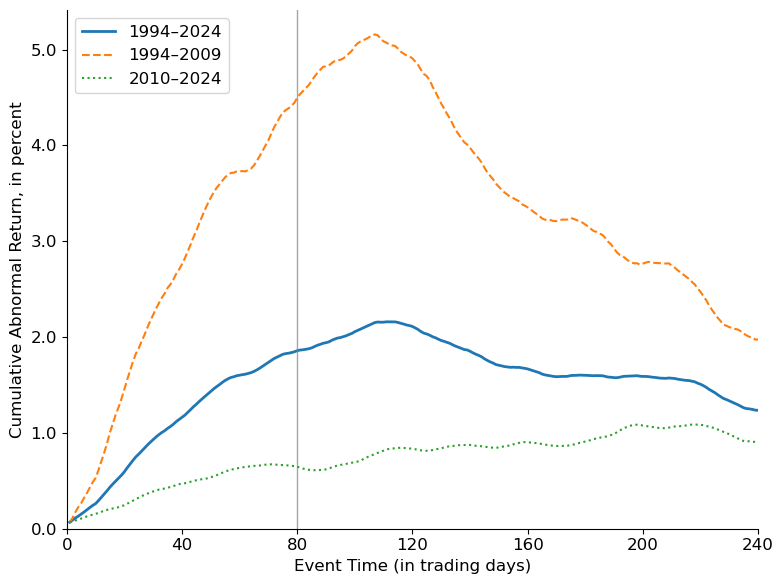

In [37]:
import os
import sys
import gc
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from pathlib import Path

# =================================================================================================
# EVENT-TIME CUMULATIVE ABNORMAL RETURN (CAR) PLOT - REGRESSION BASED
# =================================================================================================

# -------------------------------------------------------------------------
# 1. CONFIGURATION
# -------------------------------------------------------------------------

# --- PATHS ---
# Assuming these variables are defined in your environment
try:
    DATA_FOLDER = Path(Temp_file_path_R)
    OUTPUT_FOLDER = Path(Output_file_path)
except NameError:
    DATA_FOLDER = Path(".")
    OUTPUT_FOLDER = Path(".")

# --- VISUAL SETTINGS (NEW: FONT SIZE 12) ---
plt.rcParams.update({
    'font.size': 12,          # Default text size
    'axes.labelsize': 12,     # Axis labels (x and y)
    'xtick.labelsize': 12,    # X-axis tick numbers
    'ytick.labelsize': 12,    # Y-axis tick numbers
    'legend.fontsize': 12     # Legend text
})

# --- TIME PERIODS ---
START_YEAR = 1994
END_YEAR   = 2024
EARLY_START = 1994
EARLY_END   = 2009
LATE_START  = 2010
LATE_END    = 2024

# --- PLOT SETTINGS ---
VERTICAL_LINE_AT = 80
X_LIMIT_MAX      = 240

# --- ANOMALY DEFINITIONS ---
ANOMALY_CONFIG = {
    "acc": (1, 10), "ag": (1, 10), "at": (10, 1), "cat": (10, 1),
    "cpm": (10, 1), "ec": (10, 1), "es": (10, 1), "gp": (10, 1),
    "ig": (1, 10), "inv": (1, 10), "ltg": (10, 1), "nca": (1, 10),
    "noa": (1, 10), "nwc": (1, 10), "ol": (10, 1), "osc": (1, 10),
    "pm": (10, 1), "poa": (1, 10), "pro": (10, 1), "pta": (1, 10),
    "roe": (10, 1), "rs": (10, 1), "sg": (1, 10), "sli": (10, 1),
    "slx": (10, 1), "tx": (10, 1), "txf": (1, 10),
}

# --- REGRESSION SPECIFICS ---
FACTOR_COLS = ["mktrf", "smb", "rmw", "cma", "umd"]
FORMULA = "eret ~ 1 + hedge * (mktrf + smb + rmw + cma + umd)"

# -------------------------------------------------------------------------
# 2. DATA LOADING & PREPARATION
# -------------------------------------------------------------------------

print("Step 1: Loading and Stacking Replication Data...")

df_list = []

for stem, (long_dec, short_dec) in ANOMALY_CONFIG.items():
    filename = f"{stem}_Replication_Daily_clean.parquet"
    fpath = DATA_FOLDER / filename
    
    if not fpath.exists():
        continue
        
    try:
        tmp = pd.read_parquet(fpath)
        
        rename_map = {
            "Mkt-RF": "mktrf", "SMB": "smb", "RMW": "rmw", 
            "CMA": "cma", "Mom": "umd", "RF": "rf", "Rf": "rf"
        }
        tmp.rename(columns=rename_map, inplace=True)
        
        if "ret" in tmp.columns and "rf" in tmp.columns:
            tmp["eret"] = tmp["ret"] - tmp["rf"]
        elif "ret" in tmp.columns and "eret" not in tmp.columns:
             tmp["eret"] = tmp["ret"]
        
        dcol = "Decile_Replication" if "Decile_Replication" in tmp.columns else "Decile"
        if dcol not in tmp.columns:
            continue

        tmp["hedge"] = np.nan
        tmp.loc[tmp[dcol] == long_dec, "hedge"] = 1
        tmp.loc[tmp[dcol] == short_dec, "hedge"] = 0
        
        mask_valid = (
            (tmp["hedge"].isin([0, 1])) & 
            (tmp["EventDate"].between(1, X_LIMIT_MAX)) &
            (tmp["eret"].notna())
        )
        tmp = tmp[mask_valid].copy()
        
        keep_cols = ["DayDate", "EventDate", "hedge", "eret"] + FACTOR_COLS
        
        if all(col in tmp.columns for col in keep_cols):
            df_list.append(tmp[keep_cols])
            
    except Exception as e:
        print(f"Skipping {stem}: {e}")

if not df_list:
    raise ValueError("No valid data found. Check DATA_FOLDER path and file names.")

df_all = pd.concat(df_list, ignore_index=True)
del df_list
gc.collect()

df_all["DayDate"] = pd.to_datetime(df_all["DayDate"])
df_all["Year"] = df_all["DayDate"].dt.year

print(f"Total Rows Loaded: {len(df_all):,}")

# -------------------------------------------------------------------------
# 3. HELPER FUNCTION: COMPUTE DAILY ALPHAS
# -------------------------------------------------------------------------

def compute_daily_alphas(sub_df, period_name):
    print(f"Processing Period: {period_name}...")
    
    if sub_df.empty:
        return pd.Series(dtype=float)

    avg_anomaly = (
        sub_df.groupby(["DayDate", "EventDate", "hedge"])[["eret"] + FACTOR_COLS]
        .mean()
        .reset_index()
    )
    
    daily_alphas = []
    
    for t in range(1, X_LIMIT_MAX + 1):
        day_data = avg_anomaly[avg_anomaly["EventDate"] == t].copy()
        
        if day_data["hedge"].nunique() < 2 or len(day_data) < 30:
            daily_alphas.append({"EventDate": t, "Alpha_Daily": 0.0})
            continue

        try:
            model = smf.ols(FORMULA, data=day_data)
            res = model.fit()
            alpha = res.params["hedge"]
            daily_alphas.append({"EventDate": t, "Alpha_Daily": alpha})
        except Exception:
            daily_alphas.append({"EventDate": t, "Alpha_Daily": 0.0})
            
    res_df = pd.DataFrame(daily_alphas)
    if res_df.empty:
        return pd.Series(dtype=float)

    res_df["Alpha_Pct"] = res_df["Alpha_Daily"] * 100.0
    res_df["CAR_Pct"] = res_df["Alpha_Pct"].cumsum()

    SMOOTHING_WINDOW = 10 
    res_df["CAR_Pct"] = res_df["CAR_Pct"].rolling(window=SMOOTHING_WINDOW, min_periods=1).mean()
    
    return res_df.set_index("EventDate")["CAR_Pct"]

# -------------------------------------------------------------------------
# 4. RUN PERIODS
# -------------------------------------------------------------------------

mask_full = df_all["Year"].between(START_YEAR, END_YEAR)
mask_early = df_all["Year"].between(EARLY_START, EARLY_END)
mask_late = df_all["Year"].between(LATE_START, LATE_END)

car_full = compute_daily_alphas(df_all[mask_full], f"Full ({START_YEAR}-{END_YEAR})")
car_early = compute_daily_alphas(df_all[mask_early], f"Early ({EARLY_START}-{EARLY_END})")
car_late = compute_daily_alphas(df_all[mask_late], f"Late ({LATE_START}-{LATE_END})")

car_combined = pd.DataFrame({
    f"{START_YEAR}–{END_YEAR}": car_full,
    f"{EARLY_START}–{EARLY_END}": car_early,
    f"{LATE_START}–{LATE_END}": car_late
})

# -------------------------------------------------------------------------
# 5. PLOTTING
# -------------------------------------------------------------------------

print("Generating Plot...")

fig, ax = plt.subplots(figsize=(8, 6))

lbl_full = f"{START_YEAR}–{END_YEAR}"
lbl_early = f"{EARLY_START}–{EARLY_END}"
lbl_late = f"{LATE_START}–{LATE_END}"

if lbl_full in car_combined.columns:
    ax.plot(car_combined.index, car_combined[lbl_full], 
            linestyle="-", linewidth=2, label=lbl_full, color="tab:blue")

if lbl_early in car_combined.columns:
    ax.plot(car_combined.index, car_combined[lbl_early], 
            linestyle="--", linewidth=1.5, label=lbl_early, color="tab:orange")

if lbl_late in car_combined.columns:
    ax.plot(car_combined.index, car_combined[lbl_late], 
            linestyle=":", linewidth=1.5, label=lbl_late, color="tab:green")

ax.axvline(x=VERTICAL_LINE_AT, color="gray", linewidth=1.0, alpha=0.7)

ax.set_xticks(np.arange(0, X_LIMIT_MAX + 1, 40))
ax.set_xlim(left=0, right=X_LIMIT_MAX)
ax.set_ylim(bottom=0)

ax.set_xlabel("Event Time (in trading days)")
ax.set_ylabel("Cumulative Abnormal Return, in percent")

formatter = mticker.FormatStrFormatter('%.1f')
ax.yaxis.set_major_formatter(formatter)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(loc="upper left")

plt.tight_layout()

output_img = OUTPUT_FOLDER / "Figure_1_Replication_Regression_CAR.png"
fig.savefig(output_img, dpi=300, bbox_inches="tight")

print(f"Done. Figure saved to: {output_img}")
plt.show()

Step 1: Loading and Stacking Replication Data...
Total Rows Loaded: 116,058,748
Processing Period: Full (Excl. 2007-2010)...
Processing Period: Early (1994-2006)...
Processing Period: Late (2011-2024)...
Generating Plot...
Done. Figure saved to: /home/jovyan/work/hpool1/pseidel/test/Output/Figure_1_Replication_Excl_Crisis.png


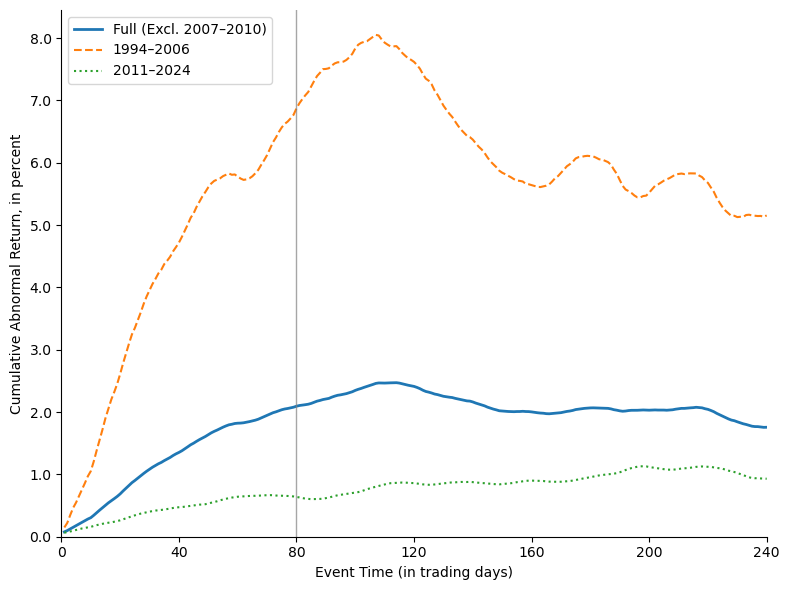

In [21]:
import os
import sys
import gc
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from pathlib import Path

# =================================================================================================
# EVENT-TIME CAR PLOT - EXCLUDING FINANCIAL CRISIS (2007-2010)
# =================================================================================================

# -------------------------------------------------------------------------
# 1. CONFIGURATION
# -------------------------------------------------------------------------

# --- PATHS ---
DATA_FOLDER = Path(Temp_file_path_R)
OUTPUT_FOLDER = Path(Output_file_path)

# --- TIME PERIODS ---
START_YEAR = 1994
END_YEAR   = 2024

# --- EXCLUSION SETTINGS ---
# We define the Crisis years to exclude from the "Full" sample
CRISIS_START = 2007
CRISIS_END   = 2010

# Early Period: Ends before the crisis
EARLY_START = 1994
EARLY_END   = 2006 

# Late Period: Starts after the crisis
LATE_START  = 2011 
LATE_END    = 2024

# --- PLOT SETTINGS ---
VERTICAL_LINE_AT = 80  
X_LIMIT_MAX      = 240 

# --- ANOMALY DEFINITIONS ---
ANOMALY_CONFIG = {
    "acc": (1, 10), "ag": (1, 10), "at": (10, 1), "cat": (10, 1),
    "cpm": (10, 1), "ec": (10, 1), "es": (10, 1), "gp": (10, 1),
    "ig": (1, 10), "inv": (1, 10), "ltg": (10, 1), "nca": (1, 10),
    "noa": (1, 10), "nwc": (1, 10), "ol": (10, 1), "osc": (1, 10),
    "pm": (10, 1), "poa": (1, 10), "pro": (10, 1), "pta": (1, 10),
    "roe": (10, 1), "rs": (10, 1), "sg": (1, 10), "sli": (10, 1),
    "slx": (10, 1), "tx": (10, 1), "txf": (1, 10),
}

# --- REGRESSION SPECIFICS ---
FACTOR_COLS = ["mktrf", "smb", "rmw", "cma", "umd"]
FORMULA = "eret ~ 1 + hedge * (mktrf + smb + rmw + cma + umd)"

# -------------------------------------------------------------------------
# 2. DATA LOADING & PREPARATION
# -------------------------------------------------------------------------

print("Step 1: Loading and Stacking Replication Data...")

df_list = []

for stem, (long_dec, short_dec) in ANOMALY_CONFIG.items():
    filename = f"{stem}_Replication_Daily_clean.parquet"
    fpath = DATA_FOLDER / filename
    
    if not fpath.exists():
        continue
        
    try:
        tmp = pd.read_parquet(fpath)
        
        rename_map = {
            "Mkt-RF": "mktrf", "SMB": "smb", "RMW": "rmw", 
            "CMA": "cma", "Mom": "umd", "RF": "rf", "Rf": "rf"
        }
        tmp.rename(columns=rename_map, inplace=True)
        
        if "ret" in tmp.columns and "rf" in tmp.columns:
            tmp["eret"] = tmp["ret"] - tmp["rf"]
        elif "ret" in tmp.columns:
             tmp["eret"] = tmp["ret"]
        
        dcol = "Decile_Replication" if "Decile_Replication" in tmp.columns else "Decile"
        if dcol not in tmp.columns:
            continue

        tmp["hedge"] = np.nan
        tmp.loc[tmp[dcol] == long_dec, "hedge"] = 1
        tmp.loc[tmp[dcol] == short_dec, "hedge"] = 0
        
        mask_valid = (
            (tmp["hedge"].isin([0, 1])) & 
            (tmp["EventDate"].between(1, X_LIMIT_MAX)) &
            (tmp["eret"].notna())
        )
        tmp = tmp[mask_valid].copy()
        
        keep_cols = ["DayDate", "EventDate", "hedge", "eret"] + FACTOR_COLS
        
        if all(col in tmp.columns for col in keep_cols):
            df_list.append(tmp[keep_cols])
            
    except Exception as e:
        print(f"Skipping {stem}: {e}")

if not df_list:
    raise ValueError("No valid data found.")

df_all = pd.concat(df_list, ignore_index=True)
del df_list
gc.collect()

df_all["DayDate"] = pd.to_datetime(df_all["DayDate"])
df_all["Year"] = df_all["DayDate"].dt.year

print(f"Total Rows Loaded: {len(df_all):,}")

# -------------------------------------------------------------------------
# 3. HELPER FUNCTION: COMPUTE DAILY ALPHAS
# -------------------------------------------------------------------------

def compute_daily_alphas(sub_df, period_name):
    print(f"Processing Period: {period_name}...")
    
    if sub_df.empty:
        return pd.Series(dtype=float)

    # 1. Aggregate to 'Average Anomaly' level
    avg_anomaly = (
        sub_df.groupby(["DayDate", "EventDate", "hedge"])[["eret"] + FACTOR_COLS]
        .mean()
        .reset_index()
    )
    
    daily_alphas = []
    
    # 2. Iterate through Event Dates
    for t in range(1, X_LIMIT_MAX + 1):
        day_data = avg_anomaly[avg_anomaly["EventDate"] == t].copy()
        
        if day_data["hedge"].nunique() < 2:
            daily_alphas.append({"EventDate": t, "Alpha_Daily": 0.0})
            continue
            
        if len(day_data) < 30: 
            daily_alphas.append({"EventDate": t, "Alpha_Daily": 0.0})
            continue

        try:
            model = smf.ols(FORMULA, data=day_data)
            res = model.fit()
            alpha = res.params["hedge"]
            daily_alphas.append({"EventDate": t, "Alpha_Daily": alpha})
        except Exception:
            daily_alphas.append({"EventDate": t, "Alpha_Daily": 0.0})
            
    # 3. Process Results
    res_df = pd.DataFrame(daily_alphas)
    if res_df.empty:
        return pd.Series(dtype=float)

    res_df["Alpha_Pct"] = res_df["Alpha_Daily"] * 100.0
    res_df["CAR_Pct"] = res_df["Alpha_Pct"].cumsum()

    # Smoothing
    SMOOTHING_WINDOW = 10 
    res_df["CAR_Pct"] = res_df["CAR_Pct"].rolling(window=SMOOTHING_WINDOW, min_periods=1).mean()
    
    return res_df.set_index("EventDate")["CAR_Pct"]

# -------------------------------------------------------------------------
# 4. RUN PERIODS (WITH CRISIS EXCLUSION)
# -------------------------------------------------------------------------

# Mask: Early (Pre-Crisis)
mask_early = df_all["Year"].between(EARLY_START, EARLY_END)

# Mask: Late (Post-Crisis)
mask_late = df_all["Year"].between(LATE_START, LATE_END)

# Mask: Full Sample (EXCLUDING CRISIS)
# Logic: Take the full range, but explicitly remove rows where Year is in 2007-2010
mask_full_range = df_all["Year"].between(START_YEAR, END_YEAR)
mask_crisis     = df_all["Year"].between(CRISIS_START, CRISIS_END)
mask_full_clean = mask_full_range & (~mask_crisis)

# Compute CARs
# Note: Changing label name to indicate exclusion
car_full  = compute_daily_alphas(df_all[mask_full_clean], f"Full (Excl. {CRISIS_START}-{CRISIS_END})")
car_early = compute_daily_alphas(df_all[mask_early], f"Early ({EARLY_START}-{EARLY_END})")
car_late  = compute_daily_alphas(df_all[mask_late], f"Late ({LATE_START}-{LATE_END})")

# Combine
lbl_full  = f"Full (Excl. {CRISIS_START}–{CRISIS_END})"
lbl_early = f"{EARLY_START}–{EARLY_END}"
lbl_late  = f"{LATE_START}–{LATE_END}"

car_combined = pd.DataFrame({
    lbl_full: car_full,
    lbl_early: car_early,
    lbl_late: car_late
})

# -------------------------------------------------------------------------
# 5. PLOTTING
# -------------------------------------------------------------------------

print("Generating Plot...")

fig, ax = plt.subplots(figsize=(8, 6))

# Plot Full Sample (Solid Line)
if lbl_full in car_combined.columns:
    ax.plot(car_combined.index, car_combined[lbl_full], 
            linestyle="-", linewidth=2, label=lbl_full, color="tab:blue")

# Plot Early Sample (Dashed Line)
if lbl_early in car_combined.columns:
    ax.plot(car_combined.index, car_combined[lbl_early], 
            linestyle="--", linewidth=1.5, label=lbl_early, color="tab:orange")

# Plot Late Sample (Dotted Line)
if lbl_late in car_combined.columns:
    ax.plot(car_combined.index, car_combined[lbl_late], 
            linestyle=":", linewidth=1.5, label=lbl_late, color="tab:green")

ax.axvline(x=VERTICAL_LINE_AT, color="gray", linewidth=1.0, alpha=0.7)

# Formatting
ax.set_xticks(np.arange(0, X_LIMIT_MAX + 1, 40)) 
ax.set_xlim(left=0, right=X_LIMIT_MAX) 
ax.set_ylim(bottom=0)                  

ax.set_xlabel("Event Time (in trading days)")
ax.set_ylabel("Cumulative Abnormal Return, in percent")
formatter = mticker.FormatStrFormatter('%.1f')
ax.yaxis.set_major_formatter(formatter)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(loc="upper left")

plt.tight_layout()

# Save Output
output_img = OUTPUT_FOLDER / "Figure_1_Replication_Excl_Crisis.png"
fig.savefig(output_img, dpi=300, bbox_inches="tight")

print(f"Done. Figure saved to: {output_img}")
plt.show()

### Figure 2: Percent of Firms with December Fiscal Year-end

#### Replication

In [9]:
# =============================================================================
# SUMMARY
# =============================================================================
# This script performs the following end-to-end workflow:
#
#   PART A — ID COLLECTION AND CHARACTERISTICS FILTERING
#   ----------------------------------------------------
#   1. Load all files matching "*_clean.txt" from MERGE_DIR.
#   2. Load "FF_Benchmark_data_clean.txt" (Benchmark).
#   3. Compute the INTERSECTION of unique IDs from (1) and (2).
#   4. Load Characteristics_clean.txt.
#   5. Filter Characteristics so it contains ONLY rows in this intersection.
#
#   PART B — MERGE AND COUNTRY FILTERING
#   ------------------------------------
#   6. Load FYE_clean.txt.
#   7. Merge Characteristics onto FYE_clean.
#   8. Filter to keep only IDs in the intersection.
#   9. **FILTER BY COUNTRY CODE (124 Canada, 840 USA) IMMEDIATEY.**
#  10. **Save filtered dataset to "Figure_2_Replication_Data.txt".**
#
#   PART C — GRAPH REPLICATION
#   --------------------------
#  11. Filter years (1985-2024).
#  12. Exclude 2024 (incomplete).
#  13. Plot and save "Figure_2_Replication.png".
# =============================================================================

from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt

# =============================================================================
# CONFIGURATION
# =============================================================================
FILTER_START_DATE = "01.01.1985"
FILTER_END_DATE   = "31.12.2024"

# =============================================================================
# PART A — COLLECT IDs AND FILTER CHARACTERISTICS DATASET
# =============================================================================

MERGE_DIR = Path(Temp_file_path_A)
MERGE_PATTERN = "*_clean.txt"
BENCHMARK_FILE = Path(Temp_file_path_DP) / "FF_Benchmark_data_clean.txt"
SEP = "|"

# 1. Load IDs from MERGE_DIR
all_id_frames = []
print("--- Loading Merge Files ---")
for file_path in MERGE_DIR.glob(MERGE_PATTERN):
    try:
        df_ids = pd.read_csv(file_path, sep=SEP, usecols=['ID'], dtype={'ID': str})
        all_id_frames.append(df_ids)
        print(f"Loaded IDs from {file_path.name}: {len(df_ids)} rows.")
    except ValueError as e:
        print(f"Skipping {file_path.name}: could not read ID column ({e}).")

if not all_id_frames:
    raise RuntimeError("No IDs could be loaded from MERGE_DIR.")

ids_from_merge = pd.concat(all_id_frames, ignore_index=True)['ID'].dropna().astype(str)
unique_ids_merge_set = set(ids_from_merge.unique())

# 2. Load IDs from BENCHMARK file
print("\n--- Loading Benchmark File ---")
try:
    df_benchmark = pd.read_csv(BENCHMARK_FILE, sep=SEP, usecols=['ID'], dtype={'ID': str})
    unique_ids_benchmark_set = set(df_benchmark['ID'].dropna().astype(str).unique())
    print(f"Unique IDs found in Benchmark file: {len(unique_ids_benchmark_set)}")
except Exception as e:
    raise RuntimeError(f"Error reading Benchmark file: {e}")

# 3. Compute Intersection
valid_ids_set = unique_ids_merge_set.intersection(unique_ids_benchmark_set)
unique_ids = pd.Index(list(valid_ids_set))
print(f"\nTotal unique IDs in INTERSECTION: {len(unique_ids)}")

if len(unique_ids) == 0:
    raise RuntimeError("Intersection is empty. No data to process.")

# 4. Load Characteristics and Filter
characteristics_file = os.path.join(Temp_file_path_DP, "Characteristics_clean.txt")
characteristics_df_filtered = pd.read_csv(characteristics_file, sep=SEP, dtype={'ID': str})

characteristics_df_filtered = characteristics_df_filtered[
    characteristics_df_filtered['ID'].isin(unique_ids)
].copy()

# =============================================================================
# PART B — MERGE, COUNTRY FILTER, AND SAVE DATA
# =============================================================================

fye_file_path = os.path.join(Temp_file_path_EoC, "FYE_clean.txt")

if 'import_file_to_dataframe' in globals():
    FYE_clean = import_file_to_dataframe(fye_file_path)
else:
    FYE_clean = pd.read_csv(fye_file_path, sep='|', dtype=str)

if FYE_clean is None:
    raise RuntimeError(f"Could not load FYE_clean.")

print(f"\nLoaded FYE_clean with {len(FYE_clean)} rows.")

FYE_clean_merge = FYE_clean.copy()
FYE_clean_merge['ID'] = FYE_clean_merge['ID'].astype(str)
characteristics_df_filtered['ID'] = characteristics_df_filtered['ID'].astype(str)

fye_with_characteristics = pd.merge(
    FYE_clean_merge,
    characteristics_df_filtered,
    on='ID',
    how='left',
    suffixes=('', '_char')
)

# 1. Strict ID Intersection Filter
fye_with_characteristics = fye_with_characteristics[
    fye_with_characteristics['ID'].isin(unique_ids)
].copy()

# 2. FILTER BY COUNTRY CODE (USA=840, CANADA=124) HERE
# Extract 2nd-4th digit (indices 1:4)
fye_with_characteristics['CountryCode'] = fye_with_characteristics['ID'].str[1:4]
fye_with_characteristics = fye_with_characteristics[
    fye_with_characteristics['CountryCode'].isin(['124', '840'])
].copy()

print(f"Rows remaining after USA/Canada filter: {len(fye_with_characteristics)}")

# 3. Save the FILTERED Data
Temp_file_path_TaF = f"{Temp_file_path}/TempTablesAndFigures"
os.makedirs(Temp_file_path_TaF, exist_ok=True)
output_fye_char_file = os.path.join(Temp_file_path_TaF, "Figure_2_Replication_Data.txt")

fye_with_characteristics.to_csv(output_fye_char_file, sep='|', index=False)
print(f"\nUSA/Canada filtered dataset saved to:\n{output_fye_char_file}")

# =============================================================================
# PART C — GRAPH REPLICATION
# =============================================================================

plot_df = fye_with_characteristics.copy()
plot_df['FY'] = pd.to_numeric(plot_df['FY'], errors='coerce')
plot_df = plot_df.dropna(subset=['FY'])

# --- Date Filter ---
try:
    start_year = int(FILTER_START_DATE.split('.')[-1])
    end_year = int(FILTER_END_DATE.split('.')[-1])
    plot_df = plot_df[(plot_df['FY'] >= start_year) & (plot_df['FY'] <= end_year)]
except Exception:
    pass

# --- Exclude 2024 ---
plot_df = plot_df[plot_df['FY'] != 2024]

if len(plot_df) == 0:
    print("Warning: No data left for plotting.")
else:
    # Normalize FYE month
    month_series = plot_df['FYE Month'].astype(str).str.strip().str.lower()
    is_december = month_series.isin(['12', 'dec', 'dec.', 'december'])

    # Calculate Percentages
    total_per_year = plot_df.groupby('FY')['ID'].nunique()
    december_per_year = plot_df[is_december].groupby('FY')['ID'].nunique()
    december_per_year = december_per_year.reindex(total_per_year.index, fill_value=0)

    percent_december = 100 * december_per_year / total_per_year
    percent_december = percent_december.sort_index()

    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(percent_december.index, percent_december.values, linewidth=2)

    ax.set_xlabel("Year")
    ax.set_ylabel("Percent of Firms with December FYE")
    ax.set_ylim(50, 90)

    # X-Ticks
    years = sorted(percent_december.index.unique())
    if len(years) > 0:
        ticks = list(range(int(years[0]), int(years[-1]) + 1, 2))
        ax.set_xticks(ticks)
        ax.set_xticklabels(ticks, rotation=45)

    ax.grid(False)
    fig.tight_layout()

    output_png = os.path.join(Output_file_path, "Figure_2_Replication.png")
    fig.savefig(output_png, dpi=300, bbox_inches="tight")
    plt.close(fig)

    print(f"Replication chart saved to:\n{output_png}")

--- Loading Merge Files ---
Loaded IDs from LTG_clean.txt: 315174 rows.
Loaded IDs from INV_clean.txt: 616479 rows.
Loaded IDs from RS_clean.txt: 653797 rows.
Loaded IDs from PTA_clean.txt: 583871 rows.
Loaded IDs from CAT_clean.txt: 595339 rows.
Loaded IDs from SG_clean.txt: 1155764 rows.
Loaded IDs from IG_clean.txt: 1568892 rows.
Loaded IDs from EC_clean.txt: 297109 rows.
Loaded IDs from TXF_clean.txt: 278824 rows.
Loaded IDs from SLX_clean.txt: 660077 rows.
Loaded IDs from AT_clean.txt: 657799 rows.
Loaded IDs from GP_clean.txt: 697296 rows.
Loaded IDs from TX_clean.txt: 769338 rows.
Loaded IDs from NWC_clean.txt: 1272133 rows.
Loaded IDs from PM_clean.txt: 897420 rows.
Loaded IDs from PRO_clean.txt: 702530 rows.
Loaded IDs from ES_clean.txt: 621771 rows.
Loaded IDs from NCA_clean.txt: 1279071 rows.
Loaded IDs from CPM_clean.txt: 880907 rows.
Loaded IDs from ACC_clean.txt: 435074 rows.
Loaded IDs from OL_clean.txt: 477264 rows.
Loaded IDs from POA_clean.txt: 766157 rows.
Loaded IDs

#### Global

In [10]:
# =============================================================================
# SUMMARY
# =============================================================================
# This script performs the following end-to-end workflow:
#
#   PART A — ID COLLECTION AND CHARACTERISTICS FILTERING
#   ----------------------------------------------------
#   1. Load all files matching "*_clean.txt" from MERGE_DIR (Temp_file_path_A).
#   2. Load "FF_Benchmark_data_clean.txt" from Temp_file_path_DP (Benchmark).
#   3. Compute the INTERSECTION of unique IDs from (1) and (2).
#   4. Load Characteristics_clean.txt from Temp_file_path_DP.
#   5. Filter Characteristics_clean so it contains ONLY rows whose ID appears
#      in this intersection.
#
#   PART B — MERGE WITH FYE_clean
#   ------------------------------
#   6. Load FYE_clean.txt from Temp_file_path_EoC.
#   7. Merge Characteristics onto FYE_clean.
#   8. Filter final output to strictly keep IDs in the intersection.
#   9. Save "Figure_2_Data.txt".
#
#   PART C — GRAPH
#   ------------------------------
#  10. Filter data for Years defined in CONFIGURATION (1985-2024).
#  11. **EXCLUDE 2024 data points explicitly (incomplete year).**
#  12. Plot FY vs percentage of December FYEs.
#  13. **Set Y-Axis to 50% - 90%.**
#  14. Save "Figure_2.png".
# =============================================================================

from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt

# =============================================================================
# CONFIGURATION
# =============================================================================
# Time range for filtering (Year is extracted from these dates).
FILTER_START_DATE = "01.01.1985"
FILTER_END_DATE   = "31.12.2024"

# =============================================================================
# PART A — COLLECT IDs AND FILTER CHARACTERISTICS DATASET
# =============================================================================

MERGE_DIR = Path(Temp_file_path_A)
MERGE_PATTERN = "*_clean.txt"
BENCHMARK_FILE = Path(Temp_file_path_DP) / "FF_Benchmark_data_clean.txt"
SEP = "|"

# 1. Load IDs from MERGE_DIR files (*_clean.txt)
all_id_frames = []
print("--- Loading Merge Files ---")
for file_path in MERGE_DIR.glob(MERGE_PATTERN):
    try:
        df_ids = pd.read_csv(file_path, sep=SEP, usecols=['ID'], dtype={'ID': str})
        all_id_frames.append(df_ids)
        print(f"Loaded IDs from {file_path.name}: {len(df_ids)} rows.")
    except ValueError as e:
        print(f"Skipping {file_path.name}: could not read ID column ({e}).")

if not all_id_frames:
    raise RuntimeError("No IDs could be loaded from MERGE_DIR. Check pattern '*_clean.txt'.")

# Combine and deduplicate IDs from merge files
ids_from_merge = pd.concat(all_id_frames, ignore_index=True)['ID'].dropna().astype(str)
unique_ids_merge_set = set(ids_from_merge.unique())
print(f"Unique IDs found in merge files: {len(unique_ids_merge_set)}")

# 2. Load IDs from BENCHMARK file
print("\n--- Loading Benchmark File ---")
try:
    df_benchmark = pd.read_csv(BENCHMARK_FILE, sep=SEP, usecols=['ID'], dtype={'ID': str})
    unique_ids_benchmark_set = set(df_benchmark['ID'].dropna().astype(str).unique())
    print(f"Unique IDs found in Benchmark file: {len(unique_ids_benchmark_set)}")
except FileNotFoundError:
    raise RuntimeError(f"Benchmark file not found at: {BENCHMARK_FILE}")
except Exception as e:
    raise RuntimeError(f"Error reading Benchmark file: {e}")

# 3. Compute Intersection
valid_ids_set = unique_ids_merge_set.intersection(unique_ids_benchmark_set)
unique_ids = pd.Index(list(valid_ids_set))
print(f"\nTotal unique IDs in INTERSECTION: {len(unique_ids)}")

if len(unique_ids) == 0:
    raise RuntimeError("Intersection of Merge IDs and Benchmark IDs is empty. No data to process.")

# 4. Load Characteristics
characteristics_file = os.path.join(Temp_file_path_DP, "Characteristics_clean.txt")
characteristics_df_filtered = pd.read_csv(characteristics_file, sep=SEP, dtype={'ID': str})

# Filter by the intersection of IDs
characteristics_df_filtered = characteristics_df_filtered[
    characteristics_df_filtered['ID'].isin(unique_ids)
].copy()

print(f"Rows in Characteristics_clean.txt after ID filtering: {len(characteristics_df_filtered)}")

# =============================================================================
# PART A — UNIQUE ID METRICS
# =============================================================================

print(f"\nNumber of unique IDs in filtered Characteristics: {characteristics_df_filtered['ID'].nunique()}")

unique_ids_per_country = (
    characteristics_df_filtered
    .dropna(subset=['ImplCountry'])
    .groupby('ImplCountry')['ID']
    .nunique()
    .reset_index(name='n_unique_IDs')
    .sort_values('n_unique_IDs', ascending=False)
)

print("\nNumber of unique IDs per ImplCountry:")
print(unique_ids_per_country.to_string(index=False))

# =============================================================================
# LOAD FYE_clean FROM Temp_file_path_EoC
# =============================================================================

fye_file_path = os.path.join(Temp_file_path_EoC, "FYE_clean.txt")

if 'import_file_to_dataframe' in globals():
    FYE_clean = import_file_to_dataframe(fye_file_path)
else:
    FYE_clean = pd.read_csv(fye_file_path, sep='|', dtype=str)

if FYE_clean is None:
    raise RuntimeError(f"Could not load FYE_clean from {fye_file_path}")

print(f"\nLoaded FYE_clean with {len(FYE_clean)} rows.")

# =============================================================================
# PART B — MERGE + FILTER FINAL OUTPUT
# =============================================================================

FYE_clean_merge = FYE_clean.copy()
FYE_clean_merge['ID'] = FYE_clean_merge['ID'].astype(str)
characteristics_df_filtered['ID'] = characteristics_df_filtered['ID'].astype(str)

fye_with_characteristics = pd.merge(
    FYE_clean_merge,
    characteristics_df_filtered,
    on='ID',
    how='left',
    suffixes=('', '_char')
)

# Keep only IDs that exist in our valid intersection set
fye_with_characteristics = fye_with_characteristics[
    fye_with_characteristics['ID'].isin(unique_ids)
].copy()

print(f"Rows in final output after enforcing unique-ID filtering: {len(fye_with_characteristics)}")

# =============================================================================
# SAVE OUTPUT TABLE
# =============================================================================

Temp_file_path_TaF = f"{Temp_file_path}/TempTablesAndFigures"
os.makedirs(Temp_file_path_TaF, exist_ok=True)

output_fye_char_file = os.path.join(
    Temp_file_path_TaF,
    "Figure_2_Data.txt"
)

fye_with_characteristics.to_csv(output_fye_char_file, sep='|', index=False)
print(f"\nFinal dataset saved to:\n{output_fye_char_file}")

# =============================================================================
# PART C — GRAPH: PERCENT OF FIRMS WITH DECEMBER FYE BY YEAR
# =============================================================================

plot_df = fye_with_characteristics.copy()
plot_df['FY'] = pd.to_numeric(plot_df['FY'], errors='coerce')
plot_df = plot_df.dropna(subset=['FY'])

# --- APPLY DATE FILTER ---
try:
    start_year = int(FILTER_START_DATE.split('.')[-1])
    end_year = int(FILTER_END_DATE.split('.')[-1])
    
    print(f"\nFiltering Graph Data: Years {start_year} to {end_year}")
    plot_df = plot_df[
        (plot_df['FY'] >= start_year) & 
        (plot_df['FY'] <= end_year)
    ]
except Exception as e:
    print(f"Warning: Could not parse date configuration. Showing all years. Error: {e}")

# --- REMOVE INCOMPLETE YEAR 2024 ---
# Explicitly drop 2024 data points so they are not plotted
plot_df = plot_df[plot_df['FY'] != 2024]
print("Excluded data for incomplete year 2024 from the plot.")

# Normalize FYE month
month_series = plot_df['FYE Month'].astype(str).str.strip().str.lower()
is_december = month_series.isin(['12', 'dec', 'dec.', 'december'])

# total firms per FY
total_per_year = plot_df.groupby('FY')['ID'].nunique()

# firms with December FYE per FY
december_per_year = plot_df[is_december].groupby('FY')['ID'].nunique()
december_per_year = december_per_year.reindex(total_per_year.index, fill_value=0)

percent_december = 100 * december_per_year / total_per_year
percent_december = percent_december.sort_index()

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(percent_december.index, percent_december.values, linewidth=2)

ax.set_xlabel("Year")
ax.set_ylabel("Percent of Firms with December FYE")

# --- SET Y-AXIS LIMITS (50% to 90%) ---
ax.set_ylim(50, 90)

# =============================================================================
# X-AXIS TICKS IN 2-YEAR STEPS
# =============================================================================
years = sorted(percent_december.index.unique())

if len(years) > 0:
    # Ensure ticks align with the filtered data range
    ticks = list(range(int(years[0]), int(years[-1]) + 1, 2))
else:
    ticks = []

ax.set_xticks(ticks)
ax.set_xticklabels(ticks, rotation=45)

ax.grid(False)
fig.tight_layout()

output_png = os.path.join(
    Output_file_path,
    "Figure_2.png"
)

fig.savefig(output_png, dpi=300, bbox_inches="tight")
plt.close(fig)

print(f"Line chart saved to:\n{output_png}")

--- Loading Merge Files ---
Loaded IDs from LTG_clean.txt: 315174 rows.
Loaded IDs from INV_clean.txt: 616479 rows.
Loaded IDs from RS_clean.txt: 653797 rows.
Loaded IDs from PTA_clean.txt: 583871 rows.
Loaded IDs from CAT_clean.txt: 595339 rows.
Loaded IDs from SG_clean.txt: 1155764 rows.
Loaded IDs from IG_clean.txt: 1568892 rows.
Loaded IDs from EC_clean.txt: 297109 rows.
Loaded IDs from TXF_clean.txt: 278824 rows.
Loaded IDs from SLX_clean.txt: 660077 rows.
Loaded IDs from AT_clean.txt: 657799 rows.
Loaded IDs from GP_clean.txt: 697296 rows.
Loaded IDs from TX_clean.txt: 769338 rows.
Loaded IDs from NWC_clean.txt: 1272133 rows.
Loaded IDs from PM_clean.txt: 897420 rows.
Loaded IDs from PRO_clean.txt: 702530 rows.
Loaded IDs from ES_clean.txt: 621771 rows.
Loaded IDs from NCA_clean.txt: 1279071 rows.
Loaded IDs from CPM_clean.txt: 880907 rows.
Loaded IDs from ACC_clean.txt: 435074 rows.
Loaded IDs from OL_clean.txt: 477264 rows.
Loaded IDs from POA_clean.txt: 766157 rows.
Loaded IDs

### Table I: Summary Statistics

#### Market Data (Replication)

In [11]:
# =============================================================================
# STATISTICS ON CLEANED DATASET (USA & CANADA ONLY + DATE FILTER)
# -----------------------------------------------------------------------------
# 1) Loads MarketData_clean.txt (FF_Benchmark_data_clean.txt).
# 2) Filters for Country Code 124 (Canada) and 840 (USA).
# 3) **Filters for Date Range (1994 - 2024) using column 'DayDate'.**
# 4) Computes standard summary statistics for selected columns.
# 5) Computes distribution percentiles.
# 6) Saves the results into "Table_I_Market_Replication.xlsx".
# =============================================================================

import numpy as np
import pandas as pd
import os
from pathlib import Path

# -----------------------------------------------------------------------------
# CONFIGURATION
# -----------------------------------------------------------------------------

# Input file
clean_file_path = Path(Temp_file_path_DP) / "FF_Benchmark_data_clean.txt"

# Excel summary file name for REPLICATION
stats_output_dir       = Output_file_path
stats_output_name_xlsx = "Table_I_Market_Replication.xlsx"
stats_output_path_xlsx = f"{stats_output_dir}/{stats_output_name_xlsx}"

# Date Filter Configuration
FILTER_START_DATE = "01.01.1994"
FILTER_END_DATE   = "31.12.2024"

# Columns to compute statistics for
target_columns = ["MV_USD", "ret_bps"]

# Percentiles for distribution table
distribution_percentiles = [0, 1, 5, 10, 20, 30, 40, 50,
                            60, 70, 80, 90, 95, 99, 100]

# Row labels
dist_index_labels = []
for p in distribution_percentiles:
    if p == 0:
        dist_index_labels.append("min")
    elif p == 100:
        dist_index_labels.append("max")
    else:
        dist_index_labels.append(f"p{int(p):02d}")

# -----------------------------------------------------------------------------
# SAFETY CHECK
# -----------------------------------------------------------------------------

if not os.path.exists(clean_file_path):
    raise FileNotFoundError(f"Cleaned dataset not found at: {clean_file_path}")

print("Loading cleaned dataset:")
print(clean_file_path)

os.makedirs(stats_output_dir, exist_ok=True)

# =============================================================================
# STEP 1: LOAD CLEAN DATASET
# =============================================================================

# Read CSV, ensuring ID is read as a string for substring operations
df = pd.read_csv(clean_file_path, sep="|", dtype={'ID': str})

print(f"Total rows loaded: {len(df)}")

# =============================================================================
# STEP 2: APPLY FILTERS (COUNTRY + DATE)
# =============================================================================

# --- 1. DATE FILTER (Using 'DayDate') ---
if 'DayDate' in df.columns:
    # Convert 'DayDate' column to datetime objects
    df['DayDate'] = pd.to_datetime(df['DayDate'], dayfirst=True, errors='coerce')
    
    # Parse config dates
    start_dt = pd.to_datetime(FILTER_START_DATE, dayfirst=True)
    end_dt   = pd.to_datetime(FILTER_END_DATE, dayfirst=True)
    
    # Apply filter
    df_date_filtered = df[(df['DayDate'] >= start_dt) & (df['DayDate'] <= end_dt)].copy()
    print(f"Rows after filtering dates ({FILTER_START_DATE} - {FILTER_END_DATE}): {len(df_date_filtered)}")
    df = df_date_filtered
else:
    print("Warning: 'DayDate' column not found. Skipping date filtering.")

# --- 2. COUNTRY FILTER (USA/CANADA) ---
# Extract characters at indices 1, 2, 3 (2nd, 3rd, 4th digit)
df['CountryCode'] = df['ID'].str[1:4]

# Keep only 124 (Canada) and 840 (USA)
target_countries = ['124', '840']
df_filtered = df[df['CountryCode'].isin(target_countries)].copy()

print(f"Rows after filtering for USA (840) & Canada (124): {len(df_filtered)}")

if df_filtered.empty:
    raise ValueError("No data remained after filtering.")

# Overwrite df with the filtered version for processing
df = df_filtered

# =============================================================================
# STEP 3: COMPUTE SUMMARY STATISTICS
# =============================================================================

summary_rows = []
dist_data = {}

for col in target_columns:
    if col not in df.columns:
        print(f"Column {col} not found. Skipping.")
        continue

    print(f"\n--- Computing summary statistics for: {col} ---")

    valid_vals = df[col].replace([np.inf, -np.inf], np.nan).dropna()

    if valid_vals.empty:
        print(f"Warning: No valid observations for column {col} in filtered dataset.")
        continue

    count  = valid_vals.size
    mean   = valid_vals.mean()
    std    = valid_vals.std(ddof=1) if count > 1 else np.nan
    median = valid_vals.median()
    q_vals = np.percentile(valid_vals.to_numpy(), distribution_percentiles)

    summary_rows.append({
        "Column": col,
        "Observations": count,
        "Mean": mean,
        "Std_Dev": std,
        "Median": median
    })

    dist_data[col] = q_vals

# Build output DataFrames
summary_df = pd.DataFrame(summary_rows)
distribution_df = pd.DataFrame(dist_data, index=dist_index_labels)

# =============================================================================
# STEP 4: SAVE SUMMARY TO EXCEL
# =============================================================================

with pd.ExcelWriter(stats_output_path_xlsx) as writer:
    summary_df.to_excel(writer, sheet_name="Summary", index=False)
    distribution_df.to_excel(writer, sheet_name="Distribution", index=True)

print("\n=== SUMMARY STATISTICS ===")
print(summary_df)

print("\n=== DISTRIBUTION (min / percentiles / max) ===")
print(distribution_df)

print("\nSummary Excel saved to:")
print(stats_output_path_xlsx)

Loading cleaned dataset:
/home/jovyan/work/hpool1/pseidel/test/Temp/TempDataPreparation/FF_Benchmark_data_clean.txt
Total rows loaded: 149520735


/tmp/ipykernel_1065924/639035816.py:78: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['DayDate'] = pd.to_datetime(df['DayDate'], dayfirst=True, errors='coerce')


Rows after filtering dates (01.01.1994 - 31.12.2024): 143802215
Rows after filtering for USA (840) & Canada (124): 30129469

--- Computing summary statistics for: MV_USD ---

--- Computing summary statistics for: ret_bps ---

=== SUMMARY STATISTICS ===
    Column  Observations         Mean       Std_Dev  Median
0   MV_USD      30129469  4318.932918  33765.511301  268.43
1  ret_bps      30129469     7.764350    394.666657    0.00

=== DISTRIBUTION (min / percentiles / max) ===
           MV_USD       ret_bps
min  1.000000e+01 -10000.000000
p01  1.210000e+01  -1033.007300
p05  1.802000e+01   -555.287900
p10  2.586000e+01   -364.751100
p20  4.739000e+01   -191.304300
p30  8.337000e+01    -95.946900
p40  1.484300e+02    -28.128300
p50  2.684300e+02      0.000000
p60  4.965400e+02     21.993600
p70  9.682600e+02     88.540200
p80  2.106040e+03    184.642340
p90  6.182310e+03    371.876800
p95  1.513415e+04    598.551300
p99  7.190215e+04   1258.312416
max  3.453938e+06  72345.333880

Summar

#### Market Data (Global)

In [12]:
# =============================================================================
# STATISTICS ON CLEANED DATASET (NO WINSORIZATION + DATE FILTER)
# -----------------------------------------------------------------------------
# 1) Loads MarketData_clean.txt (already processed in previous step).
# 2) **Filters for Date Range (1994 - 2024) using column 'DayDate'.**
# 3) Computes standard summary statistics for selected columns.
# 4) Computes distribution percentiles (min, p01, ..., p99, max).
# 5) Saves the results into an Excel file:
#       * "Summary"        – main summary
#       * "Distribution"   – percentile distribution
# =============================================================================

import numpy as np
import pandas as pd
import os
from pathlib import Path

# -----------------------------------------------------------------------------
# CONFIGURATION
# -----------------------------------------------------------------------------

# Input file (created by earlier winsorization step, but now treated as normal data)
clean_file_path = Path(Temp_file_path_DP) / "FF_Benchmark_data_clean.txt"

# Excel summary file
stats_output_dir       = Output_file_path
stats_output_name_xlsx = "Table_I_Market.xlsx"
stats_output_path_xlsx = f"{stats_output_dir}/{stats_output_name_xlsx}"

# Date Filter Configuration
FILTER_START_DATE = "01.01.1994"
FILTER_END_DATE   = "31.12.2024"

# Columns to compute statistics for
target_columns = ["MV_USD", "ret_bps"]

# Percentiles for distribution table
distribution_percentiles = [0, 1, 5, 10, 20, 30, 40, 50,
                            60, 70, 80, 90, 95, 99, 100]

# Row labels
dist_index_labels = []
for p in distribution_percentiles:
    if p == 0:
        dist_index_labels.append("min")
    elif p == 100:
        dist_index_labels.append("max")
    else:
        dist_index_labels.append(f"p{int(p):02d}")

# -----------------------------------------------------------------------------
# SAFETY CHECK
# -----------------------------------------------------------------------------

if not os.path.exists(clean_file_path):
    raise FileNotFoundError(f"Cleaned dataset not found at: {clean_file_path}")

print("Loading cleaned dataset:")
print(clean_file_path)

os.makedirs(stats_output_dir, exist_ok=True)

# =============================================================================
# STEP 1: LOAD CLEAN DATASET & FILTER DATES
# =============================================================================

df = pd.read_csv(clean_file_path, sep="|", dtype={'ID': str})
print(f"Total rows loaded: {len(df)}")

# --- DATE FILTER (Using 'DayDate') ---
if 'DayDate' in df.columns:
    # Convert 'DayDate' column to datetime objects
    df['DayDate'] = pd.to_datetime(df['DayDate'], dayfirst=True, errors='coerce')
    
    # Parse config dates
    start_dt = pd.to_datetime(FILTER_START_DATE, dayfirst=True)
    end_dt   = pd.to_datetime(FILTER_END_DATE, dayfirst=True)
    
    # Apply filter
    df_date_filtered = df[(df['DayDate'] >= start_dt) & (df['DayDate'] <= end_dt)].copy()
    print(f"Rows after filtering dates ({FILTER_START_DATE} - {FILTER_END_DATE}): {len(df_date_filtered)}")
    
    if df_date_filtered.empty:
        raise ValueError("No data remained after date filtering.")
        
    df = df_date_filtered
else:
    print("Warning: 'DayDate' column not found. Skipping date filtering.")

# =============================================================================
# STEP 2: COMPUTE SUMMARY STATISTICS
# =============================================================================

summary_rows = []
dist_data = {}

for col in target_columns:
    if col not in df.columns:
        print(f"Column {col} not found. Skipping.")
        continue

    print(f"\n--- Computing summary statistics for: {col} ---")

    valid_vals = df[col].replace([np.inf, -np.inf], np.nan).dropna()

    if valid_vals.empty:
        raise ValueError(f"No valid observations for column {col}.")

    count  = valid_vals.size
    mean   = valid_vals.mean()
    std    = valid_vals.std(ddof=1) if count > 1 else np.nan
    median = valid_vals.median()
    q_vals = np.percentile(valid_vals.to_numpy(), distribution_percentiles)

    summary_rows.append({
        "Column": col,
        "Observations": count,
        "Mean": mean,
        "Std_Dev": std,
        "Median": median
    })

    dist_data[col] = q_vals

# Build output DataFrames
summary_df = pd.DataFrame(summary_rows)
distribution_df = pd.DataFrame(dist_data, index=dist_index_labels)

# =============================================================================
# STEP 3: SAVE SUMMARY TO EXCEL
# =============================================================================

with pd.ExcelWriter(stats_output_path_xlsx) as writer:
    summary_df.to_excel(writer, sheet_name="Summary", index=False)
    distribution_df.to_excel(writer, sheet_name="Distribution", index=True)

print("\n=== SUMMARY STATISTICS ===")
print(summary_df)

print("\n=== DISTRIBUTION (min / percentiles / max) ===")
print(distribution_df)

print("\nSummary Excel saved to:")
print(stats_output_path_xlsx)

Loading cleaned dataset:
/home/jovyan/work/hpool1/pseidel/test/Temp/TempDataPreparation/FF_Benchmark_data_clean.txt
Total rows loaded: 149520735


/tmp/ipykernel_1065924/2846285756.py:73: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['DayDate'] = pd.to_datetime(df['DayDate'], dayfirst=True, errors='coerce')


Rows after filtering dates (01.01.1994 - 31.12.2024): 143802215

--- Computing summary statistics for: MV_USD ---

--- Computing summary statistics for: ret_bps ---

=== SUMMARY STATISTICS ===
    Column  Observations         Mean       Std_Dev  Median
0   MV_USD     143802215  1948.767538  17965.087578   158.3
1  ret_bps     143802215     5.347147    338.649150     0.0

=== DISTRIBUTION (min / percentiles / max) ===
           MV_USD       ret_bps
min  1.000000e+01 -10000.000000
p01  1.198000e+01   -872.949058
p05  1.724000e+01   -454.545500
p10  2.362000e+01   -292.860000
p20  3.922000e+01   -146.360200
p30  6.183000e+01    -64.350100
p40  9.751000e+01     -5.977300
p50  1.583000e+02      0.000000
p60  2.673100e+02      0.000000
p70  4.746400e+02     55.508100
p80  9.408700e+02    139.282800
p90  2.599290e+03    301.945900
p95  6.211220e+03    495.899812
p99  3.156241e+04   1009.599785
max  3.453938e+06  72345.333880

Summary Excel saved to:
/home/jovyan/work/hpool1/pseidel/test/Outp

#### Accounting Data

In [14]:
from pathlib import Path
import pandas as pd
import numpy as np

# === CONFIG ===
INPUT_DIR = Path(Temp_file_path_A)
OUTPUT_DIR = Path(Output_file_path)
SEP = "|"

# --- YEAR FILTER CONFIGURATION ---
# Set the range of years to include (inclusive).
FILTER_START_YEAR = 1994
FILTER_END_YEAR   = 2024

# List of input files you want to process
input_files = [
    INPUT_DIR / "ACC_clean.txt", 
    INPUT_DIR / "AG_clean.txt", 
    INPUT_DIR / "AT_clean.txt", 
    INPUT_DIR / "CAT_clean.txt", 
    INPUT_DIR / "CPM_clean.txt", 
    INPUT_DIR / "EC_clean.txt", 
    INPUT_DIR / "ES_clean.txt", 
    INPUT_DIR / "GP_clean.txt", 
    INPUT_DIR / "IG_clean.txt", 
    INPUT_DIR / "INV_clean.txt", 
    INPUT_DIR / "LTG_clean.txt", 
    INPUT_DIR / "NCA_clean.txt", 
    INPUT_DIR / "NOA_clean.txt", 
    INPUT_DIR / "NWC_clean.txt", 
    INPUT_DIR / "OL_clean.txt", 
    INPUT_DIR / "OSC_clean.txt", 
    INPUT_DIR / "PM_clean.txt", 
    INPUT_DIR / "POA_clean.txt", 
    INPUT_DIR / "PRO_clean.txt", 
    INPUT_DIR / "PTA_clean.txt", 
    INPUT_DIR / "ROE_clean.txt", 
    INPUT_DIR / "RS_clean.txt", 
    #INPUT_DIR / "SAG_clean.txt", 
    INPUT_DIR / "SG_clean.txt", 
    INPUT_DIR / "SLI_clean.txt", 
    INPUT_DIR / "SLX_clean.txt", 
    INPUT_DIR / "TX_clean.txt", 
    INPUT_DIR / "TXF_clean.txt", 
]

# Output Excel file
excel_output_path = OUTPUT_DIR / "Table_I_Accounting.xlsx"
# ==============


def compute_summary_lastcol(df: pd.DataFrame,
                            country_pair=("124", "840")):

    df = df.copy()

    # ---- identify metric column (last column) ----
    metric_col = df.columns[-1]
    print(f"  -> Using last column '{metric_col}' as metric for summary statistics.")

    required_cols = {"ID", "FiscalPeriod"}
    missing = required_cols - set(df.columns)
    if missing:
        raise KeyError(f"Missing required columns {missing}")

    df[metric_col] = pd.to_numeric(df[metric_col], errors="coerce")
    df["FiscalPeriod"] = pd.to_numeric(df["FiscalPeriod"], errors="coerce")

    # =========================================================================
    # APPLY YEAR FILTER HERE
    # =========================================================================
    if FILTER_START_YEAR is not None and FILTER_END_YEAR is not None:
        initial_count = len(df)
        df = df[
            (df["FiscalPeriod"] >= FILTER_START_YEAR) &
            (df["FiscalPeriod"] <= FILTER_END_YEAR)
        ].copy()
        filtered_count = len(df)
        # Optional: Print debug info if needed
        # print(f"     Filtered years {FILTER_START_YEAR}-{FILTER_END_YEAR}: {initial_count} -> {filtered_count} rows.")

    clean_df = df.dropna(subset=[metric_col, "FiscalPeriod"]).copy()

    # -------- COUNTRY CODE --------
    clean_df["Country"] = clean_df["ID"].astype(str).str[1:4]

    # =============================================================================
    # 1) BASE STATS BY COUNTRY
    # =============================================================================

    summary_by_country = (
        clean_df
        .groupby("Country", dropna=False)[metric_col]
        .agg(mean="mean", std="std", median="median", n="count")
        .reset_index()
    )

    period_stats = (
        clean_df
        .groupby("Country", dropna=False)["FiscalPeriod"]
        .agg(earliest="min", latest="max")
        .reset_index()
    )

    firmyear_unique = (
        clean_df
        .sort_values(["ID", "FiscalPeriod"] + (["PIT Date"] if "PIT Date" in clean_df.columns else []))
        .drop_duplicates(subset=["ID", "FiscalPeriod"])
        .copy()
    )

    firmyear_counts = (
        firmyear_unique
        .groupby("Country", dropna=False)
        .size()
        .reset_index(name="firm_year_obs")
    )

    summary_extended = (
        summary_by_country
        .merge(period_stats, on="Country", how="left")
        .merge(firmyear_counts, on="Country", how="left")
    )

    for col in ["mean", "std", "median"]:
        summary_extended[col] = summary_extended[col].round(6)

    # =============================================================================
    # 2) OVERALL "ALL" ROW (FULL DATASET — NO EXCLUSIONS)
    # =============================================================================

    overall = {
        "Country": "ALL",
        "mean": clean_df[metric_col].mean(),
        "std": clean_df[metric_col].std(),
        "median": clean_df[metric_col].median(),
        "n": clean_df[metric_col].count(),
        "earliest": clean_df["FiscalPeriod"].min(),
        "latest": clean_df["FiscalPeriod"].max(),
        "firm_year_obs": firmyear_unique.shape[0],
    }

    for k, v in overall.items():
        if isinstance(v, (float, int)):
            overall[k] = round(v, 6)

    summary_extended = pd.concat(
        [summary_extended, pd.DataFrame([overall])],
        ignore_index=True
    )

    cols_order = [
        "Country",
        "mean",
        "std",
        "median",
        "n",
        "earliest",
        "latest",
        "firm_year_obs"
    ]
    summary_extended = summary_extended[cols_order]

    summary_extended["__is_all__"] = summary_extended["Country"].eq("ALL")
    summary_extended = summary_extended.sort_values(
        ["__is_all__", "Country"],
        ascending=[True, True]
    )
    summary_extended = summary_extended.drop(columns="__is_all__")

    # =============================================================================
    # 3) REPLICATION STATS: ONLY COUNTRIES 124 + 840
    # =============================================================================

    pair_set = set(country_pair)

    subset_rows = clean_df[clean_df["Country"].isin(pair_set)].copy()
    subset_firmyear = firmyear_unique[firmyear_unique["Country"].isin(pair_set)].copy()

    replication_stats = {
        "CountryGroup": f"{country_pair[0]}+{country_pair[1]}",
        "mean": subset_rows[metric_col].mean(),
        "std": subset_rows[metric_col].std(),
        "median": subset_rows[metric_col].median(),
        "n": subset_rows[metric_col].count(),
        "earliest": subset_rows["FiscalPeriod"].min(),
        "latest": subset_rows["FiscalPeriod"].max(),
        "firm_year_obs": subset_firmyear.shape[0],
    }

    for k, v in replication_stats.items():
        if isinstance(v, (float, int)):
            replication_stats[k] = round(v, 6)
            
    # We return 'overall' as well now so we can build the Global Summary table
    return summary_extended, replication_stats, overall


# =============================================================================
# MAIN LOOP
# =============================================================================

summaries = {}
replication_rows = []
global_rows = []  # <--- New list for the "Global Summary" tab

for input_path in input_files:
    print("\n" + "=" * 80)
    print(f"Processing summary for file: {input_path}")

    try:
        df_in = pd.read_csv(input_path, sep=SEP)
        
        # Unpack 3 values now
        summary_df, repl_stats, overall_stats = compute_summary_lastcol(df_in)

        sheet_name = input_path.stem[:31]
        summaries[sheet_name] = summary_df

        # 1. Store Replication Stats
        repl_stats["Dataset"] = sheet_name
        replication_rows.append(repl_stats)
        
        # 2. Store Global Stats (The "ALL" row)
        # We structure it exactly like the replication row
        overall_stats["Dataset"] = sheet_name
        overall_stats["CountryGroup"] = "ALL"  # Explicit label for the new table
        # Remove the old "Country" key if it exists to avoid confusion
        if "Country" in overall_stats:
            del overall_stats["Country"]
            
        global_rows.append(overall_stats)
    except Exception as e:
        print(f"Skipping {input_path.name} due to error: {e}")

# --- Create DataFrames ---
replication_df = pd.DataFrame(replication_rows)
global_df = pd.DataFrame(global_rows)  # <--- New DataFrame

# --- Column Ordering ---
common_cols_order = [
    "Dataset",
    "CountryGroup",
    "mean",
    "std",
    "median",
    "n",
    "earliest",
    "latest",
    "firm_year_obs",
]

# Ensure columns exist before filtering (handles empty cases)
if not replication_df.empty:
    replication_df = replication_df[common_cols_order]
if not global_df.empty:
    global_df = global_df[common_cols_order]

# --- Write to Excel ---
with pd.ExcelWriter(excel_output_path) as writer:
    # 1. Write the new Global Summary FIRST
    global_df.to_excel(writer, sheet_name="Global_Summary", index=False)
    
    # 2. Write the Replication Summary
    replication_df.to_excel(writer, sheet_name="Replication", index=False)
    
    # 3. Write individual sheets
    for sheet_name, summary_df in summaries.items():
        summary_df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"\nSaved Excel workbook with {2 + len(summaries)} sheets to:\n  {excel_output_path}")


Processing summary for file: /home/jovyan/work/hpool1/pseidel/test/Temp/TempAnomalies/ACC_clean.txt
  -> Using last column 'acc' as metric for summary statistics.

Processing summary for file: /home/jovyan/work/hpool1/pseidel/test/Temp/TempAnomalies/AG_clean.txt
  -> Using last column 'ag' as metric for summary statistics.

Processing summary for file: /home/jovyan/work/hpool1/pseidel/test/Temp/TempAnomalies/AT_clean.txt
  -> Using last column 'at' as metric for summary statistics.

Processing summary for file: /home/jovyan/work/hpool1/pseidel/test/Temp/TempAnomalies/CAT_clean.txt
  -> Using last column 'cat' as metric for summary statistics.

Processing summary for file: /home/jovyan/work/hpool1/pseidel/test/Temp/TempAnomalies/CPM_clean.txt
  -> Using last column 'cpm' as metric for summary statistics.

Processing summary for file: /home/jovyan/work/hpool1/pseidel/test/Temp/TempAnomalies/EC_clean.txt
  -> Using last column 'ec' as metric for summary statistics.

Processing summary fo


Processing file: /home/jovyan/work/hpool1/pseidel/test/Temp/TempAnomalies/ACC_clean.txt
  -> Using last column 'acc' as metric for percentiles.
     Filtered years 1994-2024: 435074 -> 424867 rows.
Percentiles of 'acc' by Country (preview):
  Country        0%        1%        5%       10%       20%       30%  \
0     025 -0.285975 -0.218357 -0.130946 -0.092454 -0.056174 -0.031508   
1     036 -0.477956 -0.284335 -0.134618 -0.085964 -0.044796 -0.025097   
2     040 -0.278364 -0.183810 -0.100583 -0.065934 -0.037234 -0.019502   
3     056 -0.346649 -0.206379 -0.104797 -0.063948 -0.039264 -0.023090   
4     060 -0.370829 -0.249326 -0.083839 -0.053638 -0.034103 -0.023389   

        40%       50%       60%       70%       80%       90%       95%  \
0 -0.012870  0.001557  0.017858  0.042209  0.076239  0.125775  0.171488   
1 -0.011645 -0.000622  0.009617  0.024998  0.046517  0.085857  0.132946   
2 -0.008720  0.001597  0.010674  0.023565  0.040380  0.073514  0.107853   
3 -0.011468 -0.0015

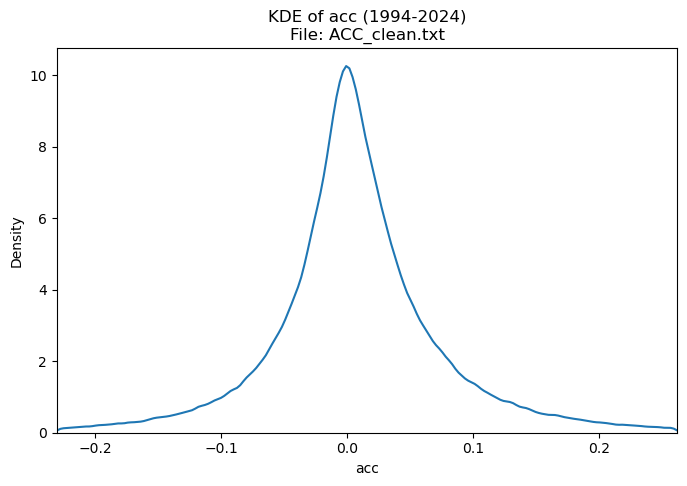


Processing file: /home/jovyan/work/hpool1/pseidel/test/Temp/TempAnomalies/AG_clean.txt
  -> Using last column 'ag' as metric for percentiles.
     Filtered years 1994-2024: 1856136 -> 1829323 rows.
Percentiles of 'ag' by Country (preview):
  Country        0%        1%        5%       10%       20%       30%  \
0     025 -0.487509 -0.310697 -0.114851 -0.050951  0.001960  0.045484   
1     036 -0.770973 -0.636302 -0.401278 -0.270371 -0.127094 -0.048783   
2     040 -0.507518 -0.340404 -0.152831 -0.092876 -0.042937 -0.013852   
3     056 -0.608431 -0.415855 -0.214464 -0.136875 -0.057931 -0.021198   
4     060 -0.613640 -0.471587 -0.243935 -0.148607 -0.070508 -0.031875   

        40%       50%       60%       70%       80%       90%       95%  \
0  0.090776  0.142329  0.207479  0.303820  0.454654  0.787635  1.342078   
1  0.004703  0.054956  0.116371  0.209505  0.380989  0.809261  1.442810   
2  0.015256  0.042438  0.071004  0.106312  0.160010  0.255450  0.398881   
3  0.007420  0.03779

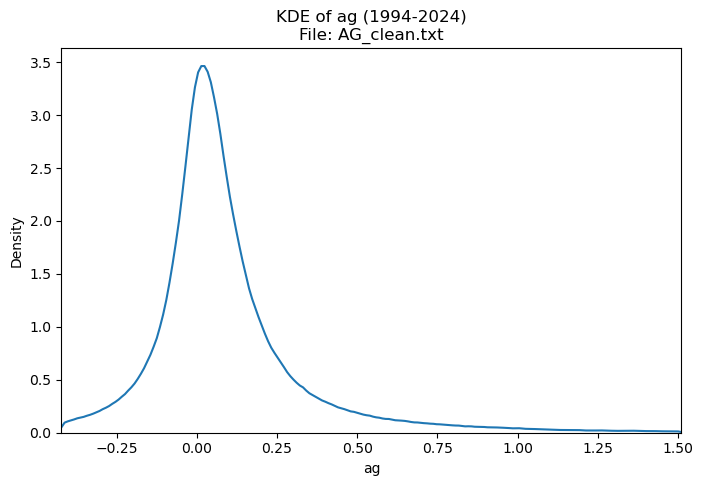


Processing file: /home/jovyan/work/hpool1/pseidel/test/Temp/TempAnomalies/AT_clean.txt
  -> Using last column 'at' as metric for percentiles.
     Filtered years 1994-2024: 657799 -> 642448 rows.
Percentiles of 'at' by Country (preview):
  Country         0%         1%        5%       10%       20%       30%  \
0     025 -23.455033  -2.741706  0.297314  0.441537  0.650779  0.872644   
1     036 -44.288696 -11.311570  0.000000  0.062296  0.369539  0.649795   
2     040 -42.564146 -16.866836  0.404974  0.702243  1.112121  1.437739   
3     056 -44.248514  -9.741911  0.039840  0.298744  0.773725  1.288960   
4     060  -0.128598   0.000000  0.041067  0.120086  0.162915  0.236445   

        40%       50%       60%       70%       80%       90%        95%  \
0  1.124578  1.525546  1.934513  2.570078  3.396698  5.318480   9.559004   
1  0.919725  1.221265  1.635896  2.179116  3.082091  5.097084   7.905332   
2  1.822731  2.224907  2.715340  3.253881  4.548563  7.226324  10.807705   
3  1.6

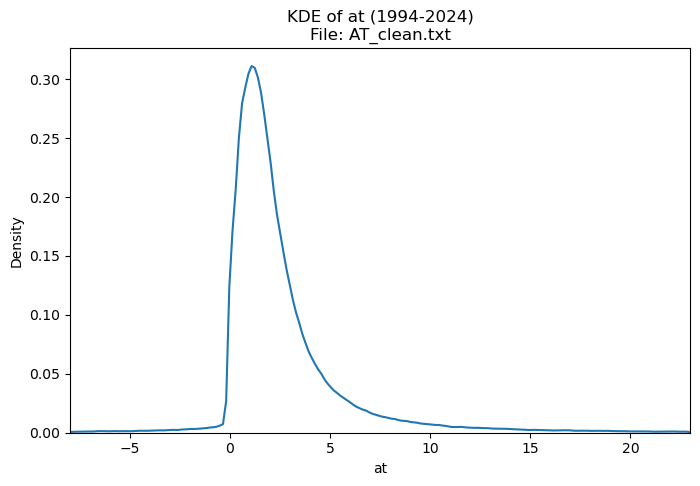


Processing file: /home/jovyan/work/hpool1/pseidel/test/Temp/TempAnomalies/CAT_clean.txt
  -> Using last column 'cat' as metric for percentiles.
     Filtered years 1994-2024: 595339 -> 580548 rows.
Percentiles of 'cat' by Country (preview):
  Country         0%         1%        5%       10%       20%       30%  \
0     025 -94.680953 -43.875513 -2.597753 -1.196054 -0.620751 -0.305805   
1     036 -86.547475 -16.843253 -2.585781 -1.009976 -0.354646 -0.160375   
2     040 -71.507742 -21.061407 -3.035015 -1.251486 -0.485163 -0.219312   
3     056 -69.502366 -13.588692 -2.285135 -0.937450 -0.368073 -0.186669   
4     060  -3.025257  -1.599172 -0.490720 -0.211074 -0.079524 -0.037526   

        40%       50%       60%       70%       80%       90%       95%  \
0 -0.128877 -0.016335  0.055460  0.140689  0.321479  0.798585  2.162721   
1 -0.057684  0.000000  0.042025  0.131073  0.285455  0.807363  1.990471   
2 -0.093779 -0.009719  0.055340  0.150044  0.330965  0.983319  2.501275   
3 -0.06

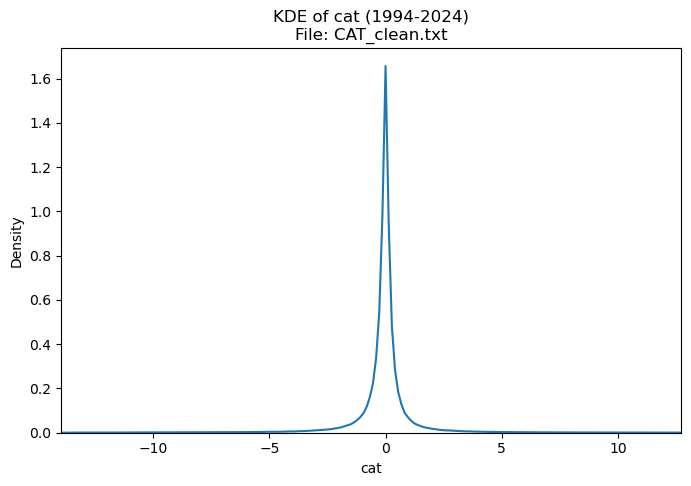


Processing file: /home/jovyan/work/hpool1/pseidel/test/Temp/TempAnomalies/CPM_clean.txt
  -> Using last column 'cpm' as metric for percentiles.
     Filtered years 1994-2024: 880907 -> 865175 rows.
Percentiles of 'cpm' by Country (preview):
  Country        0%        1%        5%       10%       20%       30%  \
0     025 -0.343025 -0.239333 -0.123100 -0.084424 -0.047727 -0.029478   
1     036 -1.979949 -0.797537 -0.278480 -0.139306 -0.054273 -0.024084   
2     040 -0.333599 -0.175502 -0.081919 -0.050201 -0.026140 -0.014889   
3     056 -0.407141 -0.268319 -0.099020 -0.055526 -0.026612 -0.014092   
4     060 -0.531907 -0.404098 -0.243436 -0.127827 -0.066942 -0.036483   

        40%       50%       60%       70%       80%       90%       95%  \
0 -0.016509 -0.003465  0.007151  0.021284  0.043240  0.082134  0.130524   
1 -0.007978  0.000000  0.010560  0.028284  0.066099  0.172778  0.325983   
2 -0.006731  0.001079  0.007024  0.014637  0.026765  0.053543  0.094288   
3 -0.005564  0.0004

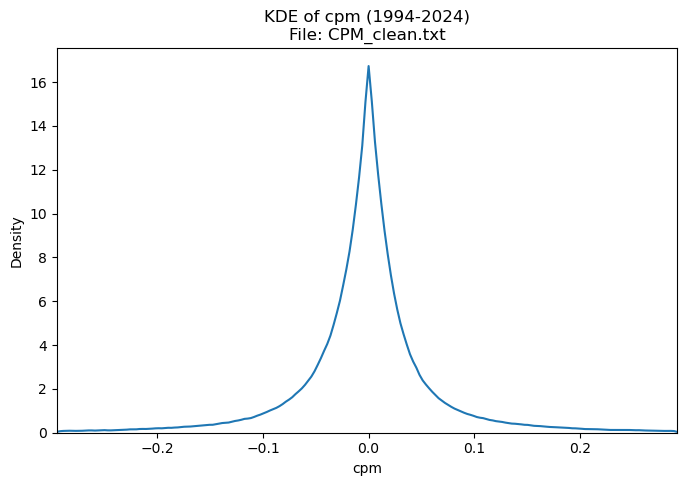


Processing file: /home/jovyan/work/hpool1/pseidel/test/Temp/TempAnomalies/EC_clean.txt
  -> Using last column 'ec' as metric for percentiles.
     Filtered years 1994-2024: 297109 -> 295404 rows.
Percentiles of 'ec' by Country (preview):
  Country        0%        1%        5%       10%       20%       30%  \
0     025 -1.683509 -0.362169 -0.167929 -0.084280  0.018431  0.085733   
1     036 -1.339091 -0.493778 -0.299466 -0.218185 -0.111331 -0.031353   
2     040 -0.555855 -0.251628 -0.152041 -0.081522  0.005495  0.055488   
3     056 -0.444256 -0.351701 -0.162285 -0.084216 -0.008377  0.034835   
4     060 -7.483404 -6.043259 -0.258201 -0.182669 -0.100691 -0.018967   

        40%       50%       60%       70%       80%       90%       95%  \
0  0.220784  0.363435  0.505131  0.714361  0.955555  1.322409  2.104177   
1  0.037683  0.100398  0.168627  0.266419  0.425721  0.821992  1.387734   
2  0.095816  0.138148  0.218228  0.284936  0.380055  0.534915  0.781234   
3  0.080702  0.125186 

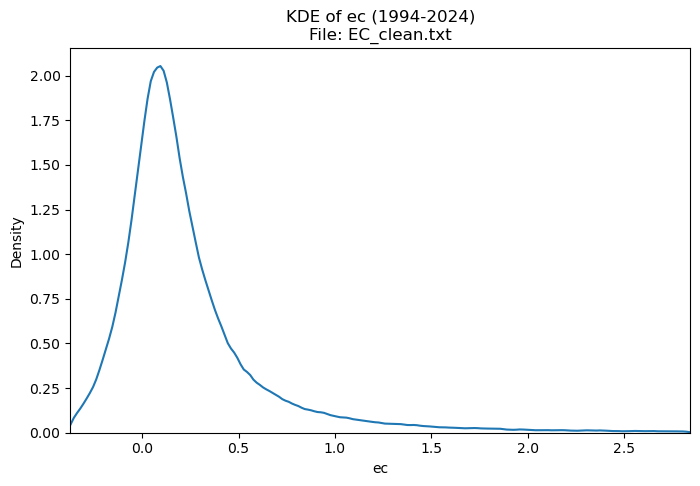


Processing file: /home/jovyan/work/hpool1/pseidel/test/Temp/TempAnomalies/ES_clean.txt
  -> Using last column 'es' as metric for percentiles.
     Filtered years 1994-2024: 621771 -> 613245 rows.
Percentiles of 'es' by Country (preview):
  Country         0%         1%        5%       10%       20%       30%  \
0     025 -44.176398 -14.891665 -5.962785 -3.582844 -1.751645 -0.841792   
1     036 -26.098831 -11.868656 -4.567538 -2.476516 -1.163698 -0.669378   
2     040 -21.669302 -14.224679 -5.075414 -3.306654 -1.635001 -0.782845   
3     056 -20.500434 -11.404333 -4.410144 -2.715489 -1.361713 -0.745762   
4     060 -13.181391 -10.215259 -4.627297 -2.294381 -1.214540 -0.625531   

        40%       50%       60%       70%       80%       90%       95%  \
0 -0.400894 -0.040982  0.344352  0.914115  1.933620  3.400345  5.944653   
1 -0.340788 -0.081419  0.141878  0.494989  1.045901  2.058228  3.079924   
2 -0.373875 -0.064937  0.236523  0.624091  1.080454  2.165927  3.046830   
3 -0.32567

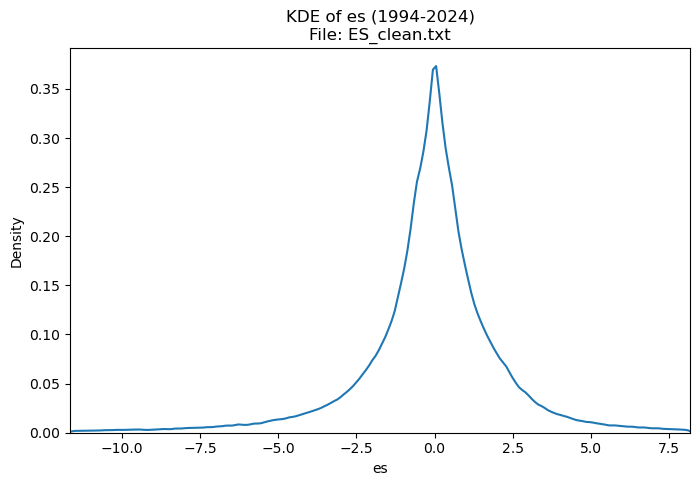


Processing file: /home/jovyan/work/hpool1/pseidel/test/Temp/TempAnomalies/GP_clean.txt
  -> Using last column 'gp' as metric for percentiles.
     Filtered years 1994-2024: 697296 -> 682261 rows.
Percentiles of 'gp' by Country (preview):
  Country        0%        1%        5%       10%       20%       30%  \
0     025  0.000000  0.002329  0.074581  0.111068  0.151525  0.180611   
1     036 -0.863371 -0.470239 -0.110599 -0.021356  0.044355  0.106621   
2     040 -0.031433  0.029436  0.081004  0.109351  0.161122  0.203685   
3     056 -0.217085 -0.071793  0.009709  0.043024  0.075909  0.108520   
4     060 -0.123973 -0.052942  0.000000  0.018916  0.069749  0.093307   

        40%       50%       60%       70%       80%       90%       95%  \
0  0.206043  0.239987  0.274269  0.321954  0.382342  0.476159  0.575184   
1  0.153490  0.205352  0.265282  0.346385  0.461026  0.666322  0.880339   
2  0.233385  0.268811  0.305291  0.342302  0.414325  0.509974  0.715090   
3  0.142942  0.176365 

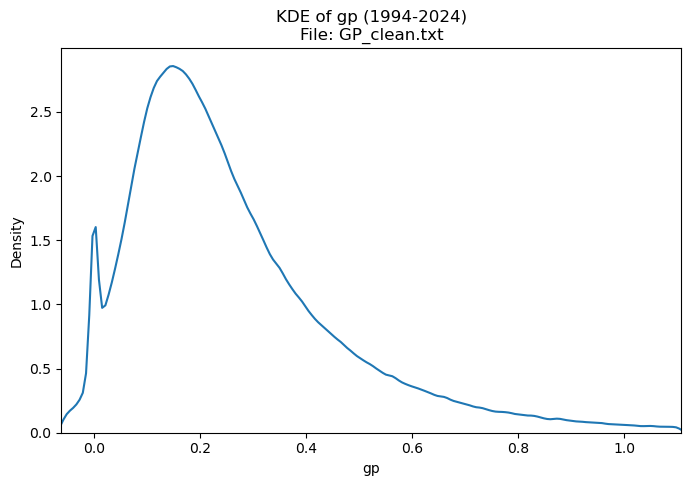


Processing file: /home/jovyan/work/hpool1/pseidel/test/Temp/TempAnomalies/IG_clean.txt
  -> Using last column 'ig' as metric for percentiles.
     Filtered years 1994-2024: 1568892 -> 1543375 rows.
Percentiles of 'ig' by Country (preview):
  Country        0%        1%        5%       10%       20%       30%  \
0     025 -0.138761 -0.081347 -0.033972 -0.012263 -0.000233  0.000860   
1     036 -0.214767 -0.122185 -0.041172 -0.016948 -0.002083  0.000000   
2     040 -0.195384 -0.099738 -0.038987 -0.022045 -0.008614 -0.001967   
3     056 -0.171951 -0.113284 -0.049005 -0.022667 -0.007805 -0.001530   
4     060 -0.106771 -0.053089 -0.012373 -0.006625 -0.002325 -0.000090   

        40%       50%       60%       70%       80%       90%       95%  \
0  0.005121  0.015151  0.031638  0.050747  0.080360  0.127112  0.174332   
1  0.000000  0.000000  0.000123  0.004249  0.015698  0.042295  0.073691   
2  0.000265  0.003303  0.008310  0.016201  0.027316  0.049216  0.071551   
3  0.000000  0.00154

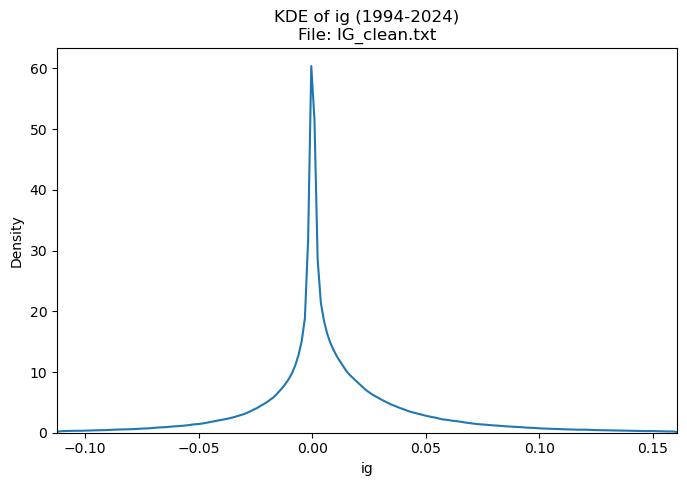


Processing file: /home/jovyan/work/hpool1/pseidel/test/Temp/TempAnomalies/INV_clean.txt
  -> Using last column 'inv' as metric for percentiles.
     Filtered years 1994-2024: 616479 -> 604207 rows.
Percentiles of 'inv' by Country (preview):
  Country        0%        1%        5%       10%       20%       30%  \
0     025  0.000000  0.000000  0.161252  0.299971  0.492275  0.625865   
1     036  0.000000  0.000000  0.096548  0.204804  0.387598  0.550057   
2     040  0.079891  0.160949  0.298093  0.438241  0.606829  0.729597   
3     056  0.000000  0.013537  0.207221  0.365044  0.537254  0.686721   
4     060  0.000000  0.000000  0.000367  0.055989  0.200882  0.380869   

        40%       50%       60%       70%       80%       90%       95%  \
0  0.771726  0.917081  1.031159  1.215614  1.471204  2.090930  2.826026   
1  0.704400  0.848981  1.009159  1.193649  1.493998  2.172357  3.093318   
2  0.826653  0.914530  1.039904  1.163199  1.357219  1.670033  2.083671   
3  0.808788  0.9236

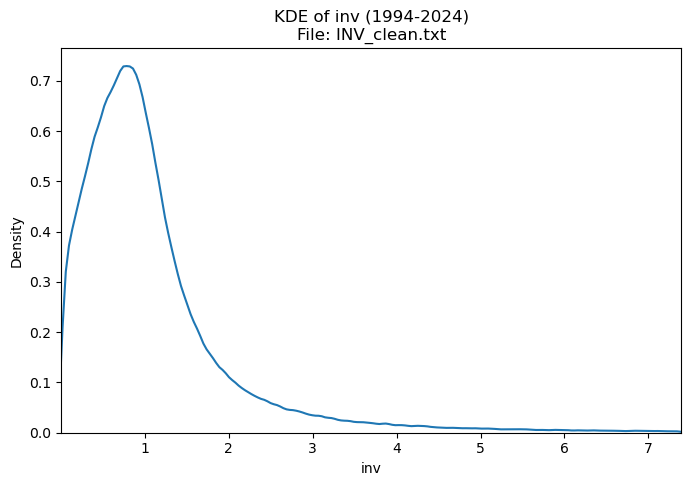


Processing file: /home/jovyan/work/hpool1/pseidel/test/Temp/TempAnomalies/LTG_clean.txt
  -> Using last column 'ltg' as metric for percentiles.
     Filtered years 1994-2024: 315174 -> 306437 rows.
Percentiles of 'ltg' by Country (preview):
  Country        0%        1%        5%       10%       20%       30%  \
0     025 -0.435949 -0.341586 -0.169462 -0.134661 -0.084539 -0.054879   
1     036 -0.716021 -0.552645 -0.246572 -0.134104 -0.064286 -0.035659   
2     040 -0.341256 -0.206027 -0.113161 -0.074304 -0.045751 -0.026778   
3     056 -0.481220 -0.338262 -0.146047 -0.083452 -0.046982 -0.025143   
4     060 -0.775603 -0.691158 -0.199008 -0.126709 -0.060959 -0.037084   

        40%       50%       60%       70%       80%       90%       95%  \
0 -0.032519 -0.012069  0.007801  0.023511  0.051629  0.101940  0.144088   
1 -0.016373 -0.000223  0.014993  0.034160  0.070382  0.151854  0.277375   
2 -0.013398 -0.004844  0.007652  0.021536  0.039578  0.075520  0.133242   
3 -0.012874 -0.0010

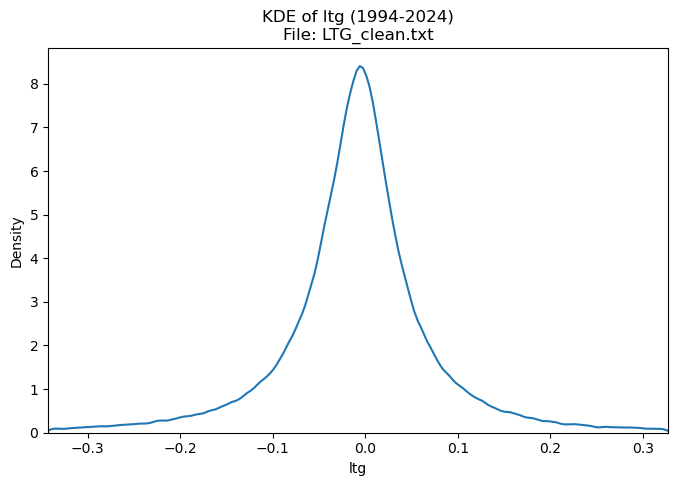


Processing file: /home/jovyan/work/hpool1/pseidel/test/Temp/TempAnomalies/NCA_clean.txt
  -> Using last column 'nca' as metric for percentiles.
     Filtered years 1994-2024: 1279071 -> 1253881 rows.
Percentiles of 'nca' by Country (preview):
  Country        0%        1%        5%       10%       20%       30%  \
0     025 -0.831979 -0.451234 -0.229567 -0.154805 -0.082779 -0.047646   
1     036 -0.951463 -0.596908 -0.276896 -0.151373 -0.064979 -0.027063   
2     040 -0.384456 -0.245184 -0.121531 -0.082206 -0.047170 -0.024444   
3     056 -0.483697 -0.293385 -0.146441 -0.093629 -0.049683 -0.025540   
4     060 -0.751829 -0.354076 -0.172877 -0.110231 -0.055084 -0.031649   

        40%       50%       60%       70%       80%       90%       95%  \
0 -0.025545 -0.002073  0.025903  0.058819  0.107726  0.204063  0.302741   
1 -0.000928  0.023459  0.052948  0.091568  0.154846  0.281917  0.425284   
2 -0.009139  0.007499  0.022444  0.039205  0.067668  0.117483  0.164597   
3 -0.007098  0.00

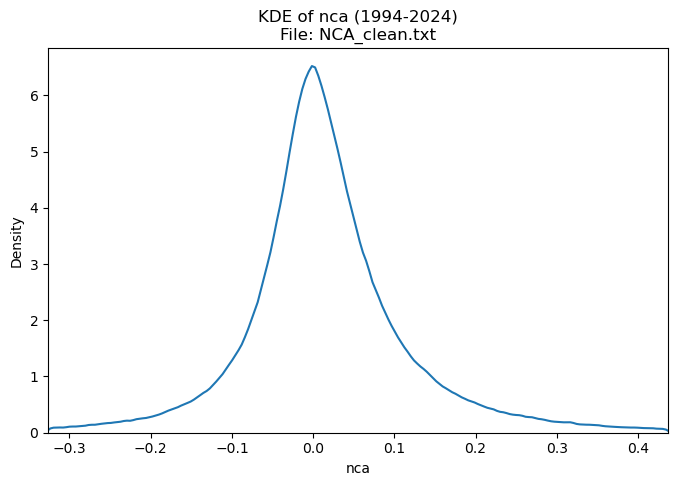


Processing file: /home/jovyan/work/hpool1/pseidel/test/Temp/TempAnomalies/NOA_clean.txt
  -> Using last column 'noa' as metric for percentiles.
     Filtered years 1994-2024: 1320977 -> 1296359 rows.
Percentiles of 'noa' by Country (preview):
  Country        0%        1%        5%       10%       20%       30%  \
0     025 -0.531838 -0.138400  0.141000  0.255483  0.395854  0.492688   
1     036 -1.037680 -0.354204 -0.012110  0.097319  0.298061  0.440889   
2     040 -0.390440 -0.095716  0.056135  0.157833  0.294025  0.395631   
3     056 -0.769112 -0.331943  0.030800  0.133985  0.274708  0.376017   
4     060 -0.143348  0.093304  0.249404  0.412086  0.561290  0.633657   

        40%       50%       60%       70%       80%       90%       95%  \
0  0.570301  0.635408  0.694066  0.750739  0.815873  0.983324  1.381579   
1  0.549443  0.634144  0.712915  0.792856  0.887037  1.045602  1.310320   
2  0.449697  0.497972  0.542514  0.589211  0.649531  0.717341  0.773991   
3  0.442781  0.50

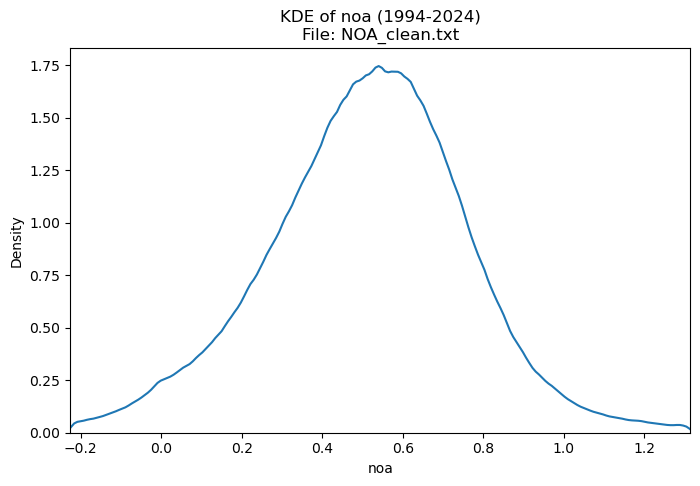


Processing file: /home/jovyan/work/hpool1/pseidel/test/Temp/TempAnomalies/NWC_clean.txt
  -> Using last column 'nwc' as metric for percentiles.
     Filtered years 1994-2024: 1272133 -> 1249730 rows.
Percentiles of 'nwc' by Country (preview):
  Country        0%        1%        5%       10%       20%       30%  \
0     025 -0.365997 -0.226160 -0.116674 -0.073586 -0.038822 -0.018231   
1     036 -0.645502 -0.383194 -0.169836 -0.101483 -0.049071 -0.024993   
2     040 -0.282457 -0.188348 -0.094191 -0.061726 -0.035140 -0.016712   
3     056 -0.354401 -0.205768 -0.101109 -0.063365 -0.034387 -0.018566   
4     060 -0.424785 -0.255405 -0.065081 -0.042577 -0.023893 -0.012743   

        40%       50%       60%       70%       80%       90%       95%  \
0 -0.004111  0.009191  0.023514  0.045901  0.076385  0.123999  0.177866   
1 -0.010312 -0.000000  0.010812  0.025891  0.050747  0.100307  0.162406   
2 -0.005736  0.004986  0.014516  0.028149  0.047624  0.079489  0.118940   
3 -0.007799  0.00

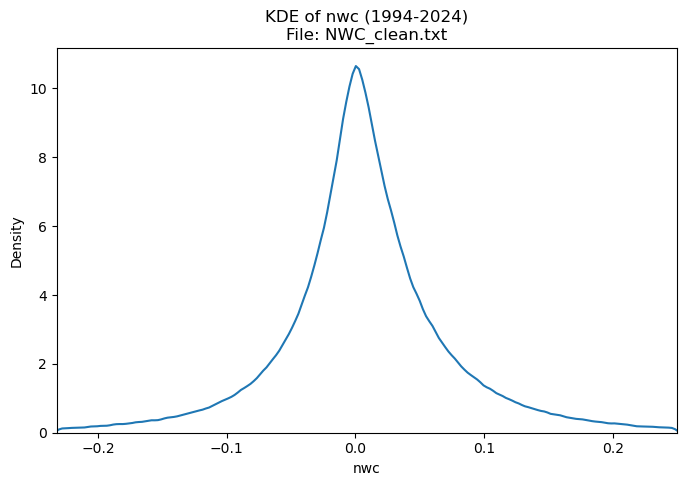


Processing file: /home/jovyan/work/hpool1/pseidel/test/Temp/TempAnomalies/OL_clean.txt
  -> Using last column 'ol' as metric for percentiles.
     Filtered years 1994-2024: 477264 -> 468893 rows.
Percentiles of 'ol' by Country (preview):
  Country        0%        1%        5%       10%       20%       30%  \
0     025  0.011563  0.020661  0.050187  0.068420  0.099892  0.127087   
1     036  0.011482  0.023471  0.052222  0.078048  0.122220  0.165620   
2     040  0.013724  0.049430  0.082741  0.102588  0.141878  0.172637   
3     056  0.024145  0.047640  0.086232  0.110162  0.148961  0.187556   
4     060  0.004505  0.008805  0.017273  0.026167  0.045107  0.060138   

        40%       50%       60%       70%       80%       90%       95%  \
0  0.149959  0.176609  0.206218  0.240003  0.286107  0.368180  0.480461   
1  0.213441  0.266012  0.328332  0.409862  0.536999  0.785084  1.086468   
2  0.199695  0.227534  0.257962  0.302652  0.400305  0.538945  0.780086   
3  0.223152  0.265803 

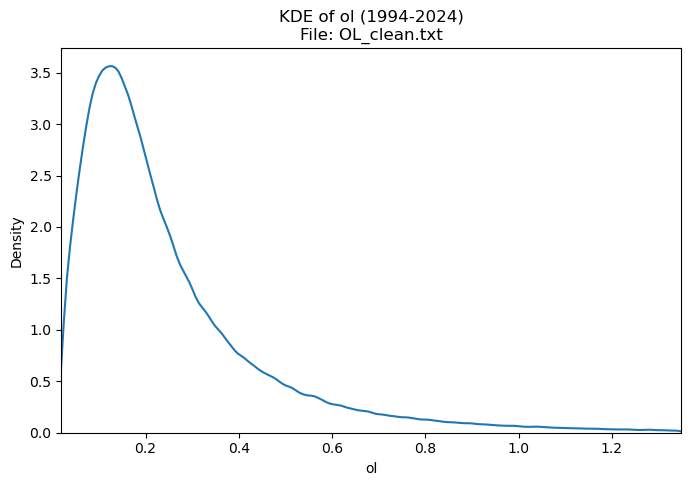


Processing file: /home/jovyan/work/hpool1/pseidel/test/Temp/TempAnomalies/OSC_clean.txt
  -> Using last column 'osc' as metric for percentiles.
     Filtered years 1994-2024: 799600 -> 783166 rows.
Percentiles of 'osc' by Country (preview):
  Country         0%        1%        5%       10%       20%       30%  \
0     025  -7.867827 -6.198728 -4.868574 -4.281159 -3.510073 -2.816664   
1     036 -10.565063 -7.100829 -4.443215 -3.383759 -2.414681 -1.798572   
2     040  -7.476190 -5.011317 -3.473914 -2.903027 -2.287569 -1.850205   
3     056  -8.235388 -6.626265 -4.430925 -3.534554 -2.411596 -1.831698   
4     060 -11.560028 -7.884958 -4.029186 -3.347532 -2.576348 -1.900526   

        40%       50%       60%       70%       80%       90%       95%  \
0 -2.317684 -1.805775 -1.307550 -0.676374  0.011629  1.074658  1.994147   
1 -1.244493 -0.684694 -0.028130  0.879640  2.242767  4.785980  7.876551   
2 -1.491914 -1.104533 -0.667204 -0.192910  0.367261  1.391711  2.657014   
3 -1.397185 -

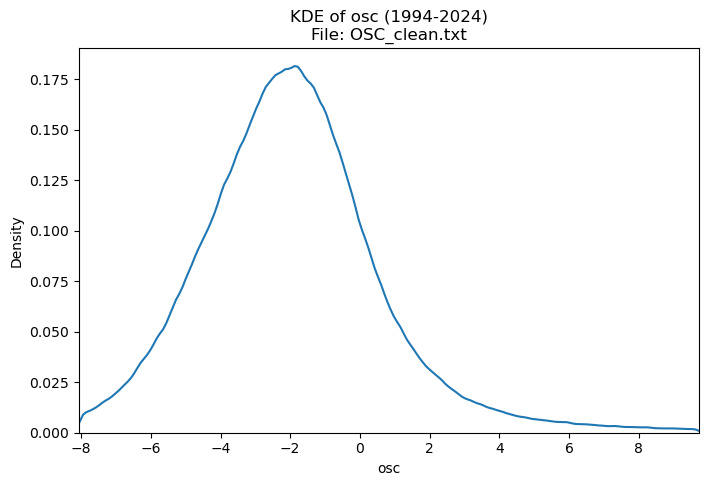


Processing file: /home/jovyan/work/hpool1/pseidel/test/Temp/TempAnomalies/PM_clean.txt
  -> Using last column 'pm' as metric for percentiles.
     Filtered years 1994-2024: 897420 -> 881520 rows.
Percentiles of 'pm' by Country (preview):
  Country        0%        1%        5%       10%       20%       30%  \
0     025 -0.001559  0.025168  0.114027  0.160094  0.226730  0.270424   
1     036 -4.715066 -2.173097 -0.395017 -0.009605  0.104115  0.168632   
2     040 -0.170518  0.048921  0.106662  0.140395  0.194174  0.231211   
3     056 -0.454658 -0.138912  0.024081  0.048930  0.079692  0.121456   
4     060 -1.208112 -0.163045  0.043447  0.145234  0.257516  0.335572   

        40%       50%       60%       70%       80%       90%       95%  \
0  0.309350  0.351733  0.393752  0.444335  0.509146  0.620891  0.707312   
1  0.232728  0.302805  0.384656  0.474527  0.586771  0.768935  0.920282   
2  0.261804  0.291334  0.324238  0.376678  0.448150  0.596263  0.748495   
3  0.180855  0.236726 

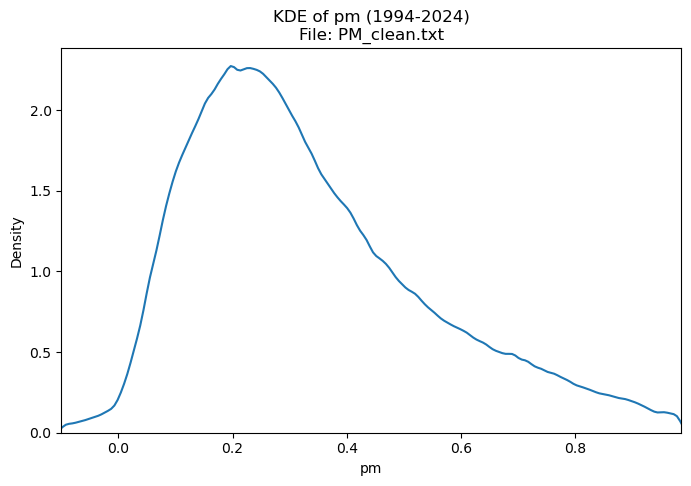


Processing file: /home/jovyan/work/hpool1/pseidel/test/Temp/TempAnomalies/POA_clean.txt
  -> Using last column 'poa' as metric for percentiles.
     Filtered years 1994-2024: 766157 -> 761797 rows.
Percentiles of 'poa' by Country (preview):
  Country         0%         1%         5%       10%       20%       30%  \
0     025 -32.017360 -22.550761  -8.032997 -4.956440 -2.726099 -1.776216   
1     036 -20.035762  -9.062412  -3.388757 -1.948645 -1.043045 -0.801469   
2     040 -32.979550 -17.890884  -8.683815 -5.346728 -2.858011 -1.961067   
3     056 -30.448454 -18.580203  -7.356205 -4.757397 -2.661543 -1.724895   
4     060 -41.298552 -25.825327 -10.581370 -5.794744 -2.648424 -1.763847   

        40%       50%       60%       70%       80%       90%       95%  \
0 -1.245860 -0.881247 -0.462053 -0.062286  0.388772  1.089581  2.250914   
1 -0.608626 -0.429402 -0.265347 -0.116714  0.064840  0.585904  1.304394   
2 -1.432415 -1.070887 -0.784068 -0.484421 -0.148502  0.447795  1.265216   
3

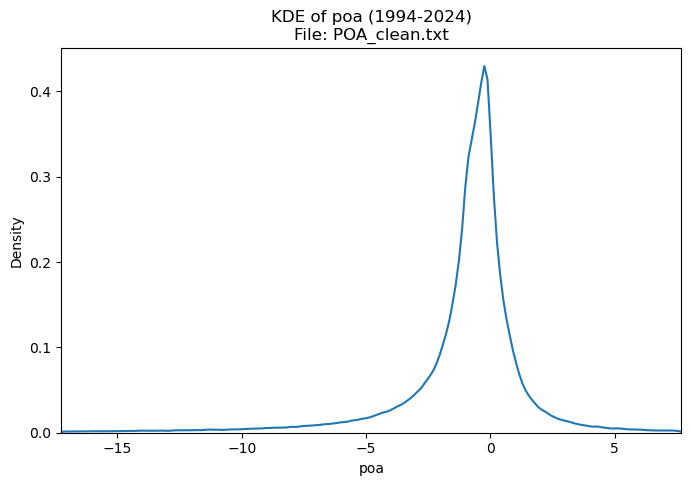


Processing file: /home/jovyan/work/hpool1/pseidel/test/Temp/TempAnomalies/PRO_clean.txt
  -> Using last column 'pro' as metric for percentiles.
     Filtered years 1994-2024: 702530 -> 690592 rows.
Percentiles of 'pro' by Country (preview):
  Country        0%        1%        5%       10%       20%       30%  \
0     025 -1.037749 -0.633623 -0.196889 -0.100375 -0.036495 -0.001383   
1     036 -3.851730 -2.136895 -1.002575 -0.668488 -0.387006 -0.231112   
2     040 -1.014939 -0.406477 -0.119306 -0.048622 -0.004309  0.012843   
3     056 -1.318317 -0.706318 -0.308169 -0.138690 -0.025773  0.007519   
4     060 -1.873817 -1.209438 -0.410728 -0.247439 -0.113915 -0.045138   

        40%       50%       60%       70%       80%       90%       95%  \
0  0.020244  0.038556  0.057826  0.078276  0.110962  0.159167  0.223074   
1 -0.130704 -0.064464 -0.003470  0.038870  0.073918  0.136840  0.209903   
2  0.024539  0.036316  0.045511  0.058716  0.074237  0.093535  0.118467   
3  0.020737  0.0333

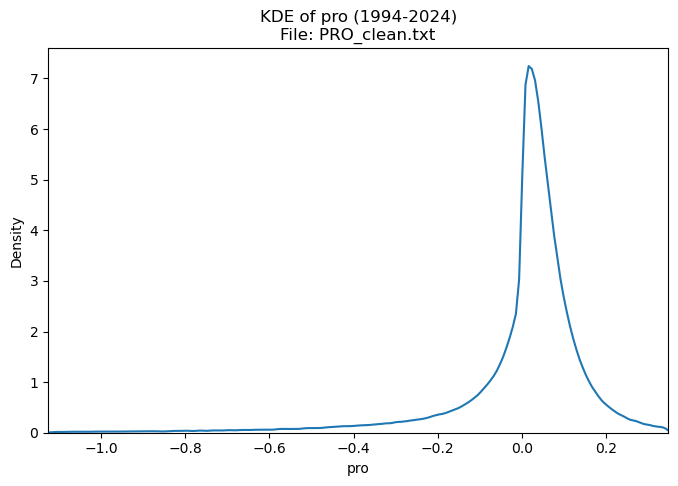


Processing file: /home/jovyan/work/hpool1/pseidel/test/Temp/TempAnomalies/PTA_clean.txt
  -> Using last column 'pta' as metric for percentiles.
     Filtered years 1994-2024: 583871 -> 579598 rows.
Percentiles of 'pta' by Country (preview):
  Country         0%        1%        5%       10%       20%       30%  \
0     025 -13.009456 -7.948205 -3.553287 -1.609662 -0.986619 -0.632308   
1     036  -9.044599 -4.388722 -1.507735 -0.999836 -0.654005 -0.310694   
2     040 -10.293364 -7.345722 -3.484350 -1.940421 -0.802406 -0.307342   
3     056 -11.420593 -6.872274 -2.620574 -1.441114 -0.792192 -0.281968   
4     060  -9.556338 -6.755979 -3.023725 -1.825976 -0.986170 -0.587988   

        40%       50%       60%       70%       80%       90%       95%  \
0 -0.097560  0.324842  0.607076  0.822970  1.038394  1.586726  2.803386   
1 -0.044976  0.198609  0.491218  0.848207  1.439074  3.018149  5.536363   
2  0.143744  0.411683  0.643010  0.876270  1.212869  2.122799  3.643402   
3  0.017430  

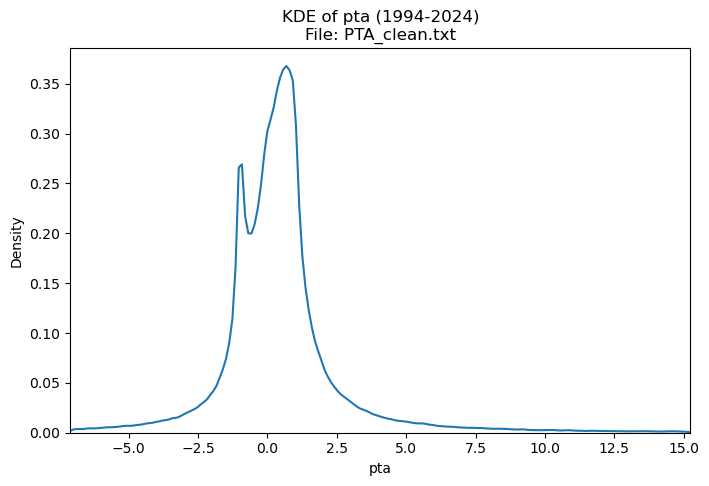


Processing file: /home/jovyan/work/hpool1/pseidel/test/Temp/TempAnomalies/ROE_clean.txt
  -> Using last column 'roe' as metric for percentiles.
     Filtered years 1994-2024: 648042 -> 637588 rows.
Percentiles of 'roe' by Country (preview):
  Country         0%        1%        5%       10%       20%       30%  \
0     025  -5.233173 -1.379173 -0.344101 -0.177969 -0.051306  0.000802   
1     036 -11.890909 -4.444420 -1.368670 -0.724648 -0.310900 -0.146156   
2     040  -8.544042 -2.140740 -0.394847 -0.142037  0.009912  0.050407   
3     056  -5.330973 -1.755703 -0.457769 -0.182319 -0.027989  0.033595   
4     060  -5.895050 -3.711163 -0.842101 -0.539210 -0.186514 -0.067825   

        40%       50%       60%       70%       80%       90%       95%  \
0  0.036565  0.066659  0.098136  0.132354  0.182544  0.265074  0.340612   
1 -0.059409  0.011409  0.066288  0.109578  0.164725  0.278406  0.438218   
2  0.074857  0.096797  0.117370  0.139600  0.171492  0.223653  0.268524   
3  0.061829  

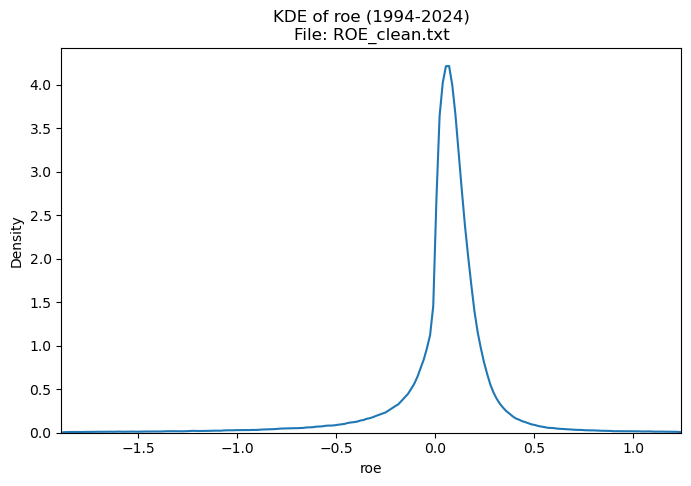


Processing file: /home/jovyan/work/hpool1/pseidel/test/Temp/TempAnomalies/RS_clean.txt
  -> Using last column 'rs' as metric for percentiles.
     Filtered years 1994-2024: 653797 -> 639799 rows.
Percentiles of 'rs' by Country (preview):
  Country         0%        1%        5%       10%       20%       30%  \
0     025 -13.051611 -6.382970 -2.887202 -1.739188 -0.907678 -0.328544   
1     036 -14.834271 -7.301592 -3.431694 -2.126314 -1.103343 -0.590843   
2     040 -16.741033 -9.004690 -3.793153 -2.329823 -1.247317 -0.625003   
3     056 -19.062023 -7.373552 -3.564497 -2.132237 -1.177465 -0.679819   
4     060 -11.718178 -8.315673 -3.263561 -2.169737 -1.076077 -0.711012   

        40%       50%       60%       70%       80%       90%       95%  \
0  0.192766  0.602351  1.083607  1.817016  2.849179  5.365155  8.696075   
1 -0.193206  0.159433  0.506547  0.884606  1.512446  3.018580  5.053173   
2 -0.204290  0.093499  0.505494  0.876707  1.421439  2.591154  3.959251   
3 -0.232041  0.1

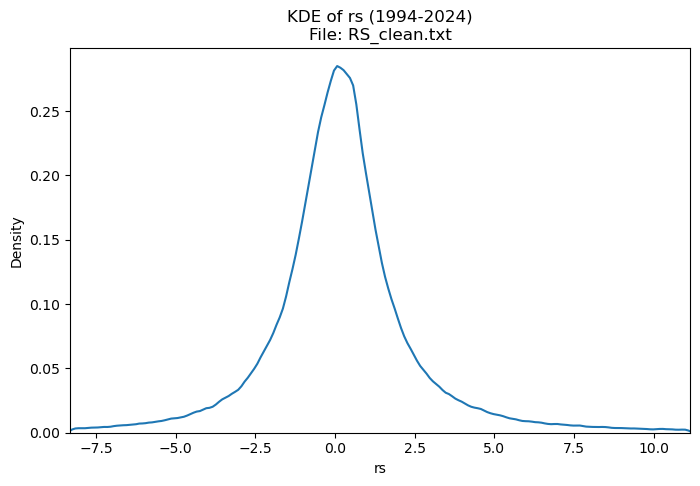


Processing file: /home/jovyan/work/hpool1/pseidel/test/Temp/TempAnomalies/SG_clean.txt
  -> Using last column 'sg' as metric for percentiles.
     Filtered years 1994-2024: 1155764 -> 1136595 rows.
Percentiles of 'sg' by Country (preview):
  Country        0%        1%        5%       10%       20%       30%  \
0     025 -3.207808 -0.992672 -0.226213 -0.108097 -0.013924  0.031308   
1     036 -5.622754 -1.379455 -0.571397 -0.347624 -0.149477 -0.046815   
2     040 -1.724599 -0.694644 -0.272275 -0.144093 -0.050598 -0.007231   
3     056 -2.804095 -0.943033 -0.342138 -0.177453 -0.067308 -0.011062   
4     060 -3.915474 -1.940208 -0.520427 -0.326709 -0.158004 -0.052924   

        40%       50%       60%       70%       80%       90%       95%  \
0  0.072777  0.124839  0.190301  0.308870  0.519153  1.040420  1.957269   
1  0.013849  0.061858  0.118918  0.207459  0.375490  0.877864  1.683494   
2  0.026876  0.053607  0.081611  0.117141  0.176075  0.300176  0.494713   
3  0.019320  0.04910

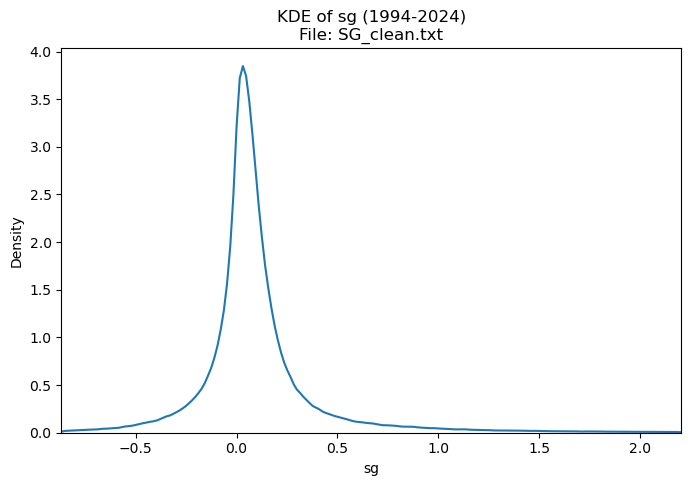


Processing file: /home/jovyan/work/hpool1/pseidel/test/Temp/TempAnomalies/SLI_clean.txt
  -> Using last column 'sli' as metric for percentiles.
     Filtered years 1994-2024: 580568 -> 565393 rows.
Percentiles of 'sli' by Country (preview):
  Country         0%        1%        5%       10%       20%       30%  \
0     025  -4.776352 -2.632093 -1.424369 -0.875517 -0.468847 -0.276398   
1     036 -10.738792 -3.837232 -1.172631 -0.626233 -0.292862 -0.142552   
2     040  -2.676993 -1.515577 -0.563605 -0.317872 -0.167396 -0.090923   
3     056  -4.820991 -1.991682 -0.664545 -0.377818 -0.175252 -0.098950   
4     060 -10.776166 -3.010946 -1.444536 -1.024113 -0.483436 -0.256369   

        40%       50%       60%       70%       80%       90%       95%  \
0 -0.134674 -0.034794  0.051264  0.138240  0.256321  0.480726  0.711583   
1 -0.050777  0.020376  0.090974  0.185056  0.327560  0.628022  0.973019   
2 -0.034854  0.011230  0.055784  0.109402  0.180091  0.341419  0.529762   
3 -0.037673  

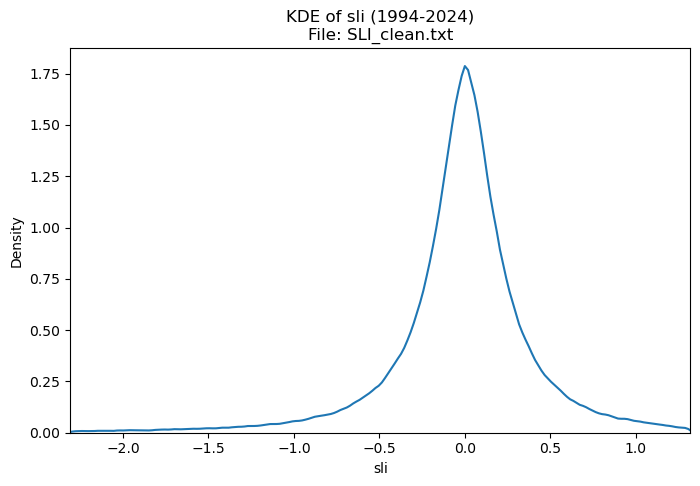


Processing file: /home/jovyan/work/hpool1/pseidel/test/Temp/TempAnomalies/SLX_clean.txt
  -> Using last column 'slx' as metric for percentiles.
     Filtered years 1994-2024: 660077 -> 649464 rows.
Percentiles of 'slx' by Country (preview):
  Country        0%        1%        5%       10%       20%       30%  \
0     025 -3.127714 -1.459441 -0.668230 -0.478107 -0.232789 -0.136322   
1     036 -4.890848 -2.053098 -0.925311 -0.540380 -0.262520 -0.123369   
2     040 -2.657341 -1.301687 -0.508815 -0.284431 -0.116847 -0.058352   
3     056 -1.778869 -1.049306 -0.487578 -0.295447 -0.141173 -0.076901   
4     060 -3.042574 -1.874626 -0.997650 -0.572122 -0.279000 -0.167404   

        40%       50%       60%       70%       80%       90%       95%  \
0 -0.068632 -0.011022  0.048377  0.122474  0.244516  0.457556  0.691538   
1 -0.050624  0.000087  0.052468  0.131015  0.277766  0.586719  0.964214   
2 -0.022163  0.010868  0.046421  0.087733  0.155339  0.265517  0.453276   
3 -0.033560 -0.0016

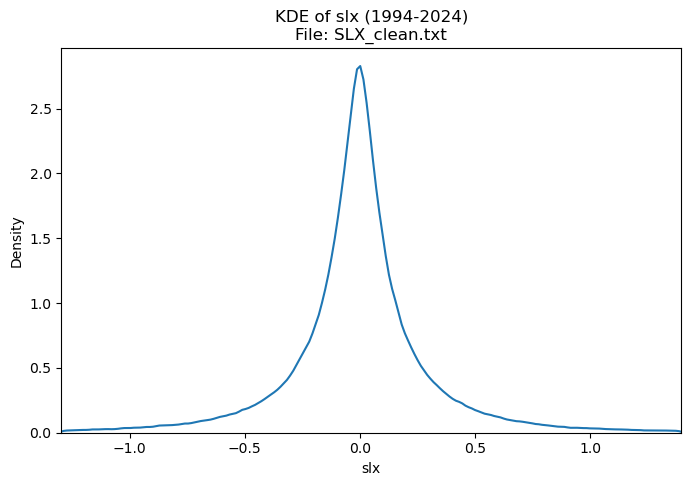


Processing file: /home/jovyan/work/hpool1/pseidel/test/Temp/TempAnomalies/TX_clean.txt
  -> Using last column 'tx' as metric for percentiles.
     Filtered years 1994-2024: 769338 -> 753240 rows.
Percentiles of 'tx' by Country (preview):
  Country         0%        1%        5%       10%       20%       30%  \
0     025 -16.691069 -8.346709 -2.084794 -0.462421  0.000000  0.151970   
1     036  -6.895134 -2.320892 -0.424569 -0.033175  0.000000  0.000000   
2     040  -6.913676 -2.856682 -0.892088 -0.312601  0.016176  0.266683   
3     056 -13.337412 -3.786367 -0.959668 -0.295191 -0.000000  0.143450   
4     060  -6.352516 -4.245347 -0.940864 -0.334833 -0.044516  0.000000   

        40%       50%       60%       70%       80%       90%       95%  \
0  0.631878  1.070197  1.457172  1.612915  1.944773  2.695927  4.612716   
1  0.000000 -0.000000  0.213525  0.844761  1.188045  1.398715  1.753765   
2  0.603209  0.832954  0.998968  1.144518  1.357301  1.758660  2.526012   
3  0.546101  0.8

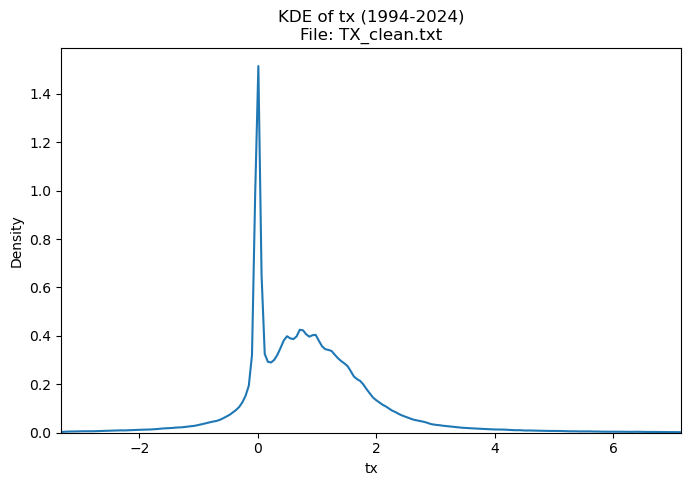


Processing file: /home/jovyan/work/hpool1/pseidel/test/Temp/TempAnomalies/TXF_clean.txt
  -> Using last column 'txf' as metric for percentiles.
     Filtered years 1994-2024: 278824 -> 267905 rows.
Percentiles of 'txf' by Country (preview):
  Country        0%        1%        5%       10%       20%       30%  \
0     025 -0.592541 -0.380143 -0.168876 -0.116519 -0.076212 -0.047949   
1     036 -0.398141 -0.266416 -0.148897 -0.100263 -0.052953 -0.021483   
2     040 -0.196585 -0.138431 -0.097694 -0.074990 -0.052498 -0.040365   
3     056 -0.359670 -0.289425 -0.154121 -0.102302 -0.066469 -0.047252   
4     060 -0.269123 -0.224502 -0.161411 -0.118669 -0.056458 -0.030513   

        40%       50%       60%       70%       80%       90%       95%  \
0 -0.028422 -0.011208  0.000000  0.021560  0.065755  0.166891  0.265168   
1  0.000000  0.020801  0.077815  0.176236  0.369372  0.825382  1.461106   
2 -0.028177 -0.013684 -0.003230  0.013640  0.046002  0.105946  0.168376   
3 -0.028258 -0.0149

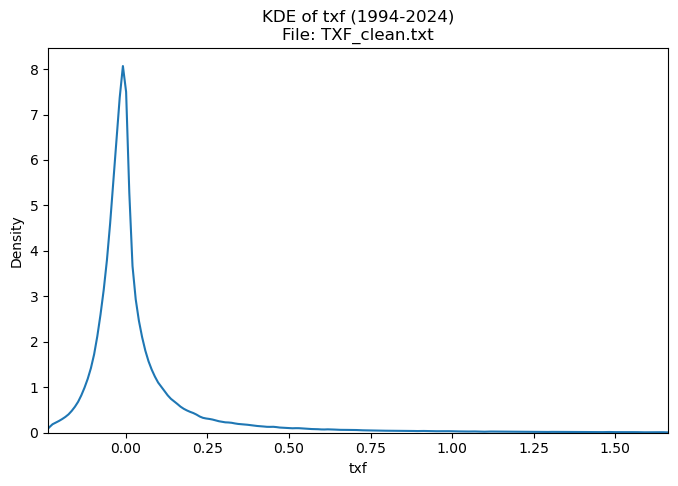


Saved Excel workbook with 27 sheets to:
  /home/jovyan/work/hpool1/pseidel/test/Output/Table_I_Accounting_Supplement.xlsx


In [15]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# =============================================================================
# CONFIG
# =============================================================================

INPUT_DIR = Path(Temp_file_path_A)
OUTPUT_DIR = Path(Output_file_path)
SEP = "|"

# --- YEAR FILTER CONFIGURATION ---
# Set the range of years to include (inclusive).
FILTER_START_YEAR = 1994
FILTER_END_YEAR   = 2024

# List of input files you want to process
input_files = [
    INPUT_DIR / "ACC_clean.txt", #1
    INPUT_DIR / "AG_clean.txt", #2
    INPUT_DIR / "AT_clean.txt", #3
    INPUT_DIR / "CAT_clean.txt", #4
    INPUT_DIR / "CPM_clean.txt", #5
    INPUT_DIR / "EC_clean.txt", #6
    INPUT_DIR / "ES_clean.txt", #7
    INPUT_DIR / "GP_clean.txt", #8
    INPUT_DIR / "IG_clean.txt", #9
    INPUT_DIR / "INV_clean.txt", #10
    INPUT_DIR / "LTG_clean.txt", #11
    INPUT_DIR / "NCA_clean.txt", #12
    INPUT_DIR / "NOA_clean.txt", #13
    INPUT_DIR / "NWC_clean.txt", #14
    INPUT_DIR / "OL_clean.txt", #15
    INPUT_DIR / "OSC_clean.txt", #16
    INPUT_DIR / "PM_clean.txt", #17
    INPUT_DIR / "POA_clean.txt", #18
    INPUT_DIR / "PRO_clean.txt", #19
    INPUT_DIR / "PTA_clean.txt", #20
    INPUT_DIR / "ROE_clean.txt", #21
    INPUT_DIR / "RS_clean.txt", #22
    #INPUT_DIR / "SAG_clean.txt", #23
    INPUT_DIR / "SG_clean.txt", #24
    INPUT_DIR / "SLI_clean.txt", #25
    INPUT_DIR / "SLX_clean.txt", #26
    INPUT_DIR / "TX_clean.txt", #27
    INPUT_DIR / "TXF_clean.txt", #28
]


# Output Excel file that will contain one sheet per input file
excel_output_path = OUTPUT_DIR / "Table_I_Accounting_Supplement.xlsx"

# Percentiles to calculate
percentiles = [0.0, 0.01, 0.05, 0.10, 0.20, 0.30, 0.40,
               0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99, 1.0]
percentile_names = [f"{int(p * 100)}%" for p in percentiles]


# =============================================================================
# HELPER: compute percentile summary for ONE dataset (metric = last column)
# =============================================================================
def compute_percentile_summary_lastcol(df: pd.DataFrame) -> (pd.DataFrame, str):
    """
    Uses the LAST column of df as the metric (converted to numeric).
    Requires column 'ID' and 'FiscalPeriod' (for filtering).
    Returns (percentile_summary, metric_col_name, filtered_df).
    """

    df = df.copy()

    # --- identify metric column (last column) ---
    metric_col = df.columns[-1]
    print(f"  -> Using last column '{metric_col}' as metric for percentiles.")

    if "ID" not in df.columns:
        raise KeyError("Column 'ID' is missing; cannot derive Country codes.")
    
    # Ensure metric and FiscalPeriod are numeric
    df[metric_col] = pd.to_numeric(df[metric_col], errors="coerce")
    if "FiscalPeriod" in df.columns:
        df["FiscalPeriod"] = pd.to_numeric(df["FiscalPeriod"], errors="coerce")
    else:
        print("  ! Warning: 'FiscalPeriod' column missing. Skipping year filter.")

    # =========================================================================
    # APPLY YEAR FILTER HERE
    # =========================================================================
    if "FiscalPeriod" in df.columns and FILTER_START_YEAR is not None and FILTER_END_YEAR is not None:
        initial_count = len(df)
        df = df[
            (df["FiscalPeriod"] >= FILTER_START_YEAR) &
            (df["FiscalPeriod"] <= FILTER_END_YEAR)
        ].copy()
        print(f"     Filtered years {FILTER_START_YEAR}-{FILTER_END_YEAR}: {initial_count} -> {len(df)} rows.")

    # Drop rows without metric
    df = df.dropna(subset=[metric_col]).copy()

    # Derive Country from ID (chars 2–4; 0-based index 1:4)
    df["Country"] = df["ID"].astype(str).str[1:4]

    # ---------------- PERCENTILE TABLE BY COUNTRY ----------------
    percentile_by_country = (
        df
        .groupby("Country", dropna=False)[metric_col]
        .quantile(percentiles)
        .unstack()
    )
    percentile_by_country.columns = percentile_names

    # ---------------- OVERALL (ALL COUNTRIES COMBINED) ----------------
    overall_percentiles = df[metric_col].quantile(percentiles).to_frame().T
    overall_percentiles.columns = percentile_names
    overall_percentiles.insert(0, "Country", "ALL")

    # ---------------- COMBINE & CLEAN ----------------
    percentile_summary = pd.concat(
        [percentile_by_country.reset_index(), overall_percentiles],
        ignore_index=True
    )

    # Round numeric columns
    for col in percentile_names:
        percentile_summary[col] = percentile_summary[col].round(6)

    # Sort: all countries alphabetically, with "ALL" at the end
    percentile_summary["__is_all__"] = percentile_summary["Country"].eq("ALL")
    percentile_summary = percentile_summary.sort_values(
        ["__is_all__", "Country"],
        ascending=[True, True]
    )
    percentile_summary = percentile_summary.drop(columns="__is_all__")

    # Return filtered DF as well so we can plot KDE on correct data
    return percentile_summary, metric_col, df


# =============================================================================
# MAIN LOOP: process all files, collect tables, and plot KDEs
# =============================================================================

summaries = {}  # sheet_name -> DataFrame

for input_path in input_files:
    print("\n" + "=" * 80)
    print(f"Processing file: {input_path}")

    try:
        # Load data
        df_in = pd.read_csv(input_path, sep=SEP)

        # Compute percentile summary (and get filtered dataframe back)
        percentile_summary, metric_col, df_filtered = compute_percentile_summary_lastcol(df_in)
        
        print(f"Percentiles of '{metric_col}' by Country (preview):")
        print(percentile_summary.head())

        # Store for Excel export (sheet name = file stem, truncated to 31 chars)
        sheet_name = input_path.stem[:31]
        summaries[sheet_name] = percentile_summary

        # ---------------- KDE PLOT FOR THIS FILE ----------------
        # 
        metric_series = df_filtered[metric_col]  # Already numeric and filtered

        if len(metric_series) > 0:
            # Trim to 1st–99th percentile to handle extreme outliers just for the plot
            lower, upper = metric_series.quantile([0.01, 0.99])
            metric_trimmed = metric_series[(metric_series >= lower) & (metric_series <= upper)]

            plt.figure(figsize=(8, 5))
            sns.kdeplot(metric_trimmed, bw_adjust=0.5)
            # x-limits adapted to trimmed range; change if you prefer fixed limits
            plt.xlim(lower, upper)
            plt.title(f"KDE of {metric_col} ({FILTER_START_YEAR}-{FILTER_END_YEAR})\nFile: {input_path.name}")
            plt.xlabel(metric_col)
            plt.ylabel("Density")
            plt.show()
        else:
            print(f"  -> No valid numeric data in '{metric_col}' to plot KDE.")
            
    except Exception as e:
        print(f"Skipping file {input_path.name} due to error: {e}")


# =============================================================================
# WRITE ALL TABLES TO ONE EXCEL FILE (ONE SHEET PER INPUT FILE)
# =============================================================================

if summaries:
    with pd.ExcelWriter(excel_output_path) as writer:  # default engine (no xlsxwriter needed)
        for sheet_name, summary_df in summaries.items():
            summary_df.to_excel(writer, sheet_name=sheet_name, index=False)

    print(f"\nSaved Excel workbook with {len(summaries)} sheets to:\n  {excel_output_path}")
else:
    print("\nNo summaries generated. Check input files.")

### Table II: The Timing of Information Releases (FF92 vs. Info Date)

In [ ]:
# =============================================================================
# TABLE II GENERATION: WITH FILTERS (NEGATIVE & 3-YEAR STALE) + REPLICATION TAB
# -----------------------------------------------------------------------------
# Logic:
#   1. Loads Parquet files.
#   2. Merges FYE Dates.
#   3. FILTER 1: Removes Negative Lags (Info < FYE).
#   4. FILTER 2: Removes Stale Lags (> 3 Years / 1095 Days).
#   5. Exports Table_II.xlsx with two sheets: "Global_Summary" and "Replication".
# =============================================================================

from pathlib import Path
import pandas as pd
import numpy as np

# -------------------------------------------------------------------
# 1) Configure
# -------------------------------------------------------------------
DATA_FOLDER = Path(Temp_file_path_R)
OUTPUT_FOLDER = Path(Output_file_path)
FYED_FILE = Path(Temp_file_path_EoC) / "FYED_clean.txt"

# -------------------------------------------------------------------
# 2) Load Parquet
# -------------------------------------------------------------------
files = sorted(DATA_FOLDER.glob("*_Information_Arrival.parquet"))
df_list = []

print(f"Loading {len(files)} parquet files...")
for path in files:
    try:
        tmp = pd.read_parquet(path)
        if "DayDate" not in tmp.columns: continue
        
        # Select & Clean
        tmp = tmp[["ID", "DayDate", "UpdateDate", "FiscalPeriod"]].copy()
        tmp["ID"] = tmp["ID"].astype(str)
        df_list.append(tmp)
    except:
        pass

if not df_list: raise ValueError("No valid data loaded.")
df_ff92 = pd.concat(df_list, ignore_index=True)

# -------------------------------------------------------------------
# 3) Merge FYE & Basic Cleaning
# -------------------------------------------------------------------
df_ff92["DayDate"] = pd.to_datetime(df_ff92["DayDate"], errors="coerce")
df_ff92 = df_ff92[(df_ff92["UpdateDate"] == 1) & (df_ff92["DayDate"].notna())].copy()

# Load FYED
df_fyed = pd.read_csv(FYED_FILE, sep="|", dtype=str)
df_ff92["FiscalPeriod_key"] = pd.to_numeric(df_ff92["FiscalPeriod"], errors="coerce")
df_fyed["FY_key"] = pd.to_numeric(df_fyed["FY"], errors="coerce")

df_ff92 = df_ff92.merge(
    df_fyed[["ID", "FY_key", "FYE Date"]],
    left_on=["ID", "FiscalPeriod_key"],
    right_on=["ID", "FY_key"],
    how="left"
)
df_ff92["FYE_Date"] = pd.to_datetime(df_ff92["FYE Date"], errors="coerce")

# -------------------------------------------------------------------
# 4) CALCULATE LAGS & APPLY FILTERS
# -------------------------------------------------------------------
# A. Calc Reporting Lag
df_ff92["FYE_Info_Diff"] = (df_ff92["DayDate"] - df_ff92["FYE_Date"]).dt.days

print(f"Total rows loaded: {len(df_ff92)}")

# FILTER 1: NEGATIVE LAGS (Impossible Data, Results from Quarterly Disclosures)
df_ff92 = df_ff92[df_ff92["FYE_Info_Diff"] >= 0].copy()
print(f"Rows after removing Negative Lags: {len(df_ff92)}")

# FILTER 2: STALE DATA (Limit set to 3 Years)
# We exclude data arriving > 1095 days (3 * 365) after FYE
STALE_THRESHOLD = 1095
df_ff92 = df_ff92[df_ff92["FYE_Info_Diff"] <= STALE_THRESHOLD].copy()
print(f"Rows after removing Stale Data (>{STALE_THRESHOLD} days): {len(df_ff92)}")

# B. Calc Other Lags (on clean data only)
def next_june_30(ts):
    if pd.isna(ts): return pd.NaT
    j30 = pd.Timestamp(ts.year, 6, 30)
    return j30 if ts <= j30 else pd.Timestamp(ts.year + 1, 6, 30)

df_ff92["Next_June_30"] = df_ff92["DayDate"].apply(next_june_30)
df_ff92["FF92_Info_Diff"] = (df_ff92["Next_June_30"] - df_ff92["DayDate"]).dt.days
df_ff92["FF92_FYE_Diff"] = (df_ff92["Next_June_30"] - df_ff92["FYE_Date"]).dt.days

# -------------------------------------------------------------------
# 5) EXPORT (Two Tabs)
# -------------------------------------------------------------------
lag_cols = ["FF92_Info_Diff", "FF92_FYE_Diff", "FYE_Info_Diff"]
renames = {c: f"{c}_mean" for c in lag_cols}

# Tab 1: Global
df_global = df_ff92.groupby("FiscalPeriod", as_index=False)[lag_cols].mean().rename(columns=renames)
df_global["FiscalPeriod"] = pd.to_numeric(df_global["FiscalPeriod"])
df_global = df_global.sort_values("FiscalPeriod")

# Tab 2: Replication (USA 840 + Canada 124)
df_ff92["Country"] = df_ff92["ID"].str[1:4]
df_repl = df_ff92[df_ff92["Country"].isin(["124", "840"])].copy()

df_replication = df_repl.groupby("FiscalPeriod", as_index=False)[lag_cols].mean().rename(columns=renames)
df_replication["FiscalPeriod"] = pd.to_numeric(df_replication["FiscalPeriod"])
df_replication = df_replication.sort_values("FiscalPeriod")

outfile = OUTPUT_FOLDER / "Table_II.xlsx"
with pd.ExcelWriter(outfile) as writer:
    df_global.to_excel(writer, sheet_name="Global_Summary", index=False)
    df_replication.to_excel(writer, sheet_name="Replication", index=False)

print(f"\nSaved Table II to: {outfile}")

Loading 27 parquet files...
Total rows loaded: 16456691
Rows after removing Negative Lags: 10447573
Rows after removing Stale Data (>1095 days): 10437984

Saved Table II to: /home/jovyan/work/hpool1/pseidel/test/Output/Table_II.xlsx


In [17]:
# =============================================================================
# INSPECTION: DIAGNOSE HIGH LAGS (YEAR MISMATCH CHECK)
# =============================================================================

# 1. Filter for the "Crazy" High Lags (e.g., > 1.5 years)
bad_lags = df_ff92[df_ff92["FYE_Info_Diff"] > 500].copy()

# 2. Extract the YEAR from the FYE_Date to compare it with FiscalPeriod
bad_lags["FYE_Year_Extract"] = bad_lags["FYE_Date"].dt.year
bad_lags["FiscalPeriod"] = pd.to_numeric(bad_lags["FiscalPeriod"])

# 3. Calculate the mismatch in years
bad_lags["Year_Mismatch"] = bad_lags["FiscalPeriod"] - bad_lags["FYE_Year_Extract"]

print(f"\n--- DIAGNOSIS REPORT ---")
print(f"Total rows with >500 day lag: {len(bad_lags)}")

if len(bad_lags) > 0:
    print("\nTop 10 Worst Offenders:")
    cols = ["ID", "FiscalPeriod", "FYE_Date", "DayDate", "FYE_Info_Diff", "Year_Mismatch"]
    print(bad_lags[cols].sort_values("FYE_Info_Diff", ascending=False).head(10))

    print("\nMismatch Summary (FiscalPeriod - FYE Year):")
    # This tells you the systematic error. 
    # If you see lots of '+1' or '-1', your merge key is off by one year.
    print(bad_lags["Year_Mismatch"].value_counts().head())
else:
    print("No extreme lags found (>500 days).")


--- DIAGNOSIS REPORT ---
Total rows with >500 day lag: 340631

Top 10 Worst Offenders:
                 ID  FiscalPeriod   FYE_Date    DayDate  FYE_Info_Diff  \
13399450  C191003Y0          2019 2019-12-31 2022-12-30         1095.0   
4144356   C03694430          2014 2014-06-30 2017-06-29         1095.0   
3545977   C392K1350          2014 2014-10-31 2017-10-30         1095.0   
6590392   C840O0140          1993 1993-08-31 1996-08-30         1095.0   
3558923   C410G7110          2010 2010-12-31 2013-12-30         1095.0   
15550831  C796X06N0          2018 2018-12-31 2021-12-30         1095.0   
6393273   C25032210          1991 1991-12-31 1994-12-30         1095.0   
3292152   C796X06N0          2018 2018-12-31 2021-12-30         1095.0   
15792344  C30070750          2002 2002-12-31 2005-12-30         1095.0   
13468571  C356A3560          2013 2013-03-31 2016-03-30         1095.0   

          Year_Mismatch  
13399450              0  
4144356               0  
3545977            

In [18]:
from pathlib import Path
import pandas as pd

# =============================================================================
# CONFIGURATION
# =============================================================================
DATA_FOLDER = Path(Temp_file_path_R)

# The specific anomalies you found (ID, FiscalPeriod)
targets = [
    ("C840R0410", 1986),
    ("C392W0990", 1983),
    ("C20851090", 1986),
    ("C392W1040", 1985),
    ("C826A9490", 1990),
    ("C82693930", 1986)
]

# Convert targets to a set for faster lookup
target_set = set((str(i), int(p)) for i, p in targets)
target_ids = set(t[0] for t in targets)

# =============================================================================
# SEARCH SCRIPT
# =============================================================================

files = sorted(DATA_FOLDER.glob("*_Information_Arrival.parquet"))

print(f"Scanning {len(files)} files for the {len(targets)} specified anomalies...\n")
print(f"{'SOURCE FILE':<40} | {'ID':<15} | {'FISCAL PERIOD':<15} | {'UPDATE DATE'}")
print("-" * 85)

found_count = 0

for path in files:
    try:
        # We only need minimal columns to identify the row
        df = pd.read_parquet(path, columns=["ID", "FiscalPeriod", "UpdateDate"])
        
        # 1. Filter for IDs first (fast)
        df["ID"] = df["ID"].astype(str)
        df = df[df["ID"].isin(target_ids)]
        
        if df.empty:
            continue
            
        # 2. Check for exact (ID, Period) matches
        df["FiscalPeriod"] = pd.to_numeric(df["FiscalPeriod"], errors="coerce")
        
        for _, row in df.iterrows():
            key = (row["ID"], int(row["FiscalPeriod"]))
            
            if key in target_set:
                print(f"{path.name:<40} | {row['ID']:<15} | {int(row['FiscalPeriod']):<15} | {row['UpdateDate']}")
                found_count += 1

    except Exception as e:
        print(f"Skipping {path.name}: {e}")

print("-" * 85)
print(f"Search complete. Found {found_count} matches.")

Scanning 27 files for the 6 specified anomalies...

SOURCE FILE                              | ID              | FISCAL PERIOD   | UPDATE DATE
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
Search complete. Found 0 matches.


### Table III

In [19]:
# =============================================================================
# Table III: Information Release Date to FF92 Rebalancing Date
# -----------------------------------------------------------------------------
# SUMMARY:
# This script analyzes the "Information Lag" (time between Info Release and
# Portfolio Formation) across 5-year buckets.
#
# INPUT:
#   - df_ff92 (DataFrame from Table II): Contains 'FiscalPeriod', 'ID', 'FF92_Info_Diff'.
#
# PROCESSING STEPS:
#   1. Filters data to the 1994–2024 period.
#   2. Groups data into 5-year buckets (e.g., 2000–2004).
#   3. Calculates key stats (Mean, Median, Std Dev, 10th/90th Percentile) for each bucket.
#   4. Adds a final "All (1994–2024)" summary row.
#   5. Runs this twice:
#       - Once for the GLOBAL dataset (all countries).
#       - Once for the REPLICATION dataset (USA & Canada only).
#
# OUTPUT:
#   - Excel File: Table_III.xlsx
#   - Sheet 1: "Global_Summary"
#   - Sheet 2: "Replication"
# =============================================================================

from pathlib import Path
import pandas as pd
import numpy as np

# --- 1. Safety Check: Ensure data exists ---
if 'df_ff92' not in locals():
    raise ValueError(
        "Dataframe 'df_ff92' not found in memory. "
        "Please run the 'Table II' cell first to load the parquet files."
    )

# --- 2. Configuration ---
try:
    OUTPUT_FOLDER = Path(Output_file_path)
except NameError:
    OUTPUT_FOLDER = Path(".") # Fallback if variable is missing

# =============================================================================
# HELPER FUNCTION: Compute Table III Stats
# =============================================================================
def compute_table_iii_stats(df_input):
    df_tmp = df_input.copy()

    # Ensure FiscalPeriod is numeric
    df_tmp["FiscalYear"] = pd.to_numeric(df_tmp["FiscalPeriod"], errors="coerce")

    # Keep only rows with valid year + info diff
    df_tmp = df_tmp.dropna(subset=["FiscalYear", "FF92_Info_Diff"]).copy()

    # --- Define Fiscal-Year Buckets (Adjusted for 1994 start) ---
    # Start at 1994. 
    # First bin: [1994, 2000) -> Covers 1994–1999 (6 years)
    # Next bins: Standard 5-year blocks
    bins = [1994, 2000, 2005, 2010, 2015, 2020, 2025]

    labels = [
        "1994–1999",
        "2000–2004",
        "2005–2009",
        "2010–2014",
        "2015–2019",
        "2020–2024",
    ]

    df_tmp["Fiscal Years"] = pd.cut(
        df_tmp["FiscalYear"],
        bins=bins,
        labels=labels,
        right=False  # [Start, End) logic
    )

    # Drop observations that fall outside our defined bins (Strict 1994-2024 filter)
    df_tmp = df_tmp.dropna(subset=["Fiscal Years"]).copy()

    # --- Compute Statistics per Bucket ---
    def p10(x): return x.quantile(0.10)
    def p90(x): return x.quantile(0.90)

    stats_df = (
        df_tmp
        .groupby("Fiscal Years", observed=False)["FF92_Info_Diff"]
        .agg([
            ("Mean", "mean"),
            ("Median", "median"),
            ("Std_Dev", "std"),
            ("10th Pctl", p10),
            ("90th Pctl", p90)
        ])
        .reset_index()
    )

    # =========================================================================
    # ADD OVERALL SUMMARY ROW (ALL YEARS 1994-2024)
    # =========================================================================
    overall_series = df_tmp["FF92_Info_Diff"]
    
    if len(overall_series) > 0:
        overall_row = pd.DataFrame({
            "Fiscal Years": ["All (1994–2024)"],  # Distinct label
            "Mean": [overall_series.mean()],
            "Median": [overall_series.median()],
            "Std_Dev": [overall_series.std()],
            "10th Pctl": [overall_series.quantile(0.10)],
            "90th Pctl": [overall_series.quantile(0.90)],
        })
        
        # Append the summary row to the bottom
        stats_df = pd.concat([stats_df, overall_row], ignore_index=True)

    # --- Formatting ---
    cols_to_round = ["Mean", "Median", "Std_Dev", "10th Pctl", "90th Pctl"]
    # Fill NaN with 0 before int conversion just in case, though usually not needed if dropna worked
    stats_df[cols_to_round] = stats_df[cols_to_round].fillna(0).round(0).astype("Int64")
    
    return stats_df


# =============================================================================
# MAIN PROCESSING
# =============================================================================

# 1. Global Summary (All Data)
print("Computing Global Summary...")
df_table3_global = compute_table_iii_stats(df_ff92)

# 2. Replication Summary (USA 840 + Canada 124)
print("Computing Replication Summary (US + Canada)...")
# Ensure Country column exists or derive it from ID
if "Country" not in df_ff92.columns:
    df_ff92["Country"] = df_ff92["ID"].astype(str).str[1:4]

# Filter for US (840) and Canada (124)
df_ff92_repl = df_ff92[df_ff92["Country"].isin(["124", "840"])].copy()
df_table3_repl = compute_table_iii_stats(df_ff92_repl)

# --- 3. Export to Excel (Two Sheets) ---
output_path_table3 = OUTPUT_FOLDER / "Table_III.xlsx"

with pd.ExcelWriter(output_path_table3) as writer:
    df_table3_global.to_excel(writer, sheet_name="Global_Summary", index=False)
    df_table3_repl.to_excel(writer, sheet_name="Replication", index=False)

print(f"\nTable III saved to: {output_path_table3}")
print("Contains sheets: 'Global_Summary' and 'Replication'")

print("\nPreview (Global with Overall Row):")
print(df_table3_global)

Computing Global Summary...
Computing Replication Summary (US + Canada)...

Table III saved to: /home/jovyan/work/hpool1/pseidel/test/Output/Table_III.xlsx
Contains sheets: 'Global_Summary' and 'Replication'

Preview (Global with Overall Row):
      Fiscal Years  Mean  Median  Std_Dev  10th Pctl  90th Pctl
0        1994–1999   194     196      103         32        333
1        2000–2004   145     111      105         28        321
2        2005–2009   127     105       90         34        285
3        2010–2014   130     105       93         35        300
4        2015–2019   118      99       76         48        244
5        2020–2024   117      99       72         55        235
6  All (1994–2024)   133     106       90         42        289


### Appendix Graphic MSCI World vs. MSCI EM

Loading data...
Generating Plot...
Done. Figure saved to: /home/jovyan/work/hpool1/pseidel/test/Output/WorldvsEM.png


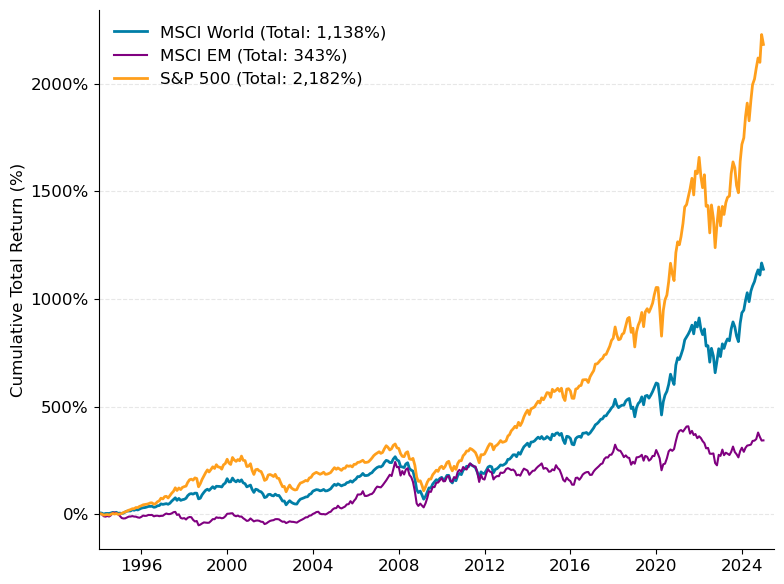

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from pathlib import Path
import numpy as np

# =================================================================================================
# CONFIGURATION
# =================================================================================================

try:
    input_path = Path(Input_file_path)
    output_path = Path(Output_file_path)
except NameError:
    input_path = Path(".")
    output_path = Path(".")

INPUT_FILE = input_path / "S&P_500.xlsx"
OUTPUT_FILE = output_path / "WorldvsEM.png"

START_YEAR = 1994
END_YEAR = 2024

# --- FONT SETTINGS ---
# We do not force 'Arial' anymore to avoid errors.
# We set the global default font size to 12, which applies to legend and axes.
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'black'

# Column Mapping
COL_DATE = "Pricing Date"
DATA_COLS = {
    "MSCI World Index USD Total Return | Total Return (Monthly)(%)": "MSCI World",
    "MSCI EM (Emerging Markets) Index Total Return | Total Return (Monthly)(%)": "MSCI EM",
    "^SPYZ | Total Return (Monthly)(%)": "S&P 500"
}

# =================================================================================================
# DATA LOADING
# =================================================================================================

print("Loading data...")
df = pd.read_excel(INPUT_FILE)

# 1. Date Setup
df[COL_DATE] = pd.to_datetime(df[COL_DATE])
df.sort_values(by=COL_DATE, inplace=True)
df.set_index(COL_DATE, inplace=True)

# 2. Clean Data
for raw_col in DATA_COLS.keys():
    if raw_col in df.columns:
        if df[raw_col].dtype == 'object':
            df[raw_col] = df[raw_col].astype(str).str.replace(',', '')
        df[raw_col] = pd.to_numeric(df[raw_col], errors='coerce')

# 3. Filter Time Period
mask = (df.index.year >= START_YEAR) & (df.index.year <= END_YEAR)
df = df.loc[mask].copy()

if df.empty:
    raise ValueError("No data found for the specified years.")

# 4. Insert 0 at Start Date
start_date = pd.Timestamp(f"{START_YEAR}-01-01")
zero_row = pd.DataFrame({col: 0.0 for col in df.columns}, index=[start_date])
df = pd.concat([zero_row, df])
df.sort_index(inplace=True)

# =================================================================================================
# PLOTTING
# =================================================================================================

print("Generating Plot...")
fig, ax = plt.subplots(figsize=(8, 6))

# Colors
styles = {
    "MSCI World": {"c": "#007ea7", "ls": "-", "lw": 2},     # Blue/Teal
    "MSCI EM":    {"c": "#800080", "ls": "-", "lw": 1.5},   # Purple
    "S&P 500":    {"c": "#ff9f1c", "ls": "-", "lw": 2}      # Orange
}

for raw_col, label in DATA_COLS.items():
    if raw_col not in df.columns:
        continue
    
    final_val = df[raw_col].iloc[-1]
    legend_label = f"{label} (Total: {final_val:,.0f}%)"
    
    s = styles.get(label, {"c": "black", "ls": "-", "lw": 1})
    
    ax.plot(df.index, df[raw_col], 
            color=s["c"], 
            linestyle=s["ls"], 
            linewidth=s["lw"], 
            label=legend_label)

# --- FORMATTING ---

ax.set_ylabel("Cumulative Total Return (%)")
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f%%'))

# Clean Layout
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.3)

# Legend (Font size explicitly set to 12, though rcParams handles it too)
ax.legend(loc="upper left", frameon=False, fontsize=12)

# Spacing
pad_days = 180 
ax.set_xlim(left=df.index[0], right=df.index[-1] + pd.Timedelta(days=pad_days))

# Y-Limits
y_min = df[list(DATA_COLS.keys())].min().min()
y_max = df[list(DATA_COLS.keys())].max().max()
ax.set_ylim(bottom=min(0, y_min) - (y_max * 0.05))

plt.tight_layout()
fig.savefig(OUTPUT_FILE, dpi=300, bbox_inches="tight")

print(f"Done. Figure saved to: {OUTPUT_FILE}")
plt.show()